# Packages, Heaviside- Funktion und Funktion der jeweils neuen Beschleunigung

In [1]:
#using Plots ; println("Plots geladen")
using PyPlot ; println("PyPlot geladen")
using Dates ; println("Dates geladen")
using CSV ; println("CSV geladen")
using DataFrames ; println("DataFrames geladen")

using ProgressMeter ; println("ProgressMeter geladen")
using InteractiveUtils ; println("InteractiveUtils geladen")


function heaviside(x)
    if x ≥ 0
        return 1
    elseif x < 0
        return 0
    else return NaN
    end
end

# Diese Funktion berechnet die neuen Beschleunigungen
# für jeden Zeitschritt

function new_accel_func(s, v, pos, v_syn, a_mx, d_par, τ_G, τ_safe,
        p1, p2, p3, p4)
    acceleration = 0
    lens = length(s)
    if pos == lens
        acceleration = a_mx
    else
        x_val   = s[pos]
        x_l_val = s[pos+1]
        v_val   = v[pos]
        v_l_val = v[pos+1]
        g       = x_l_val - x_val - d_par
        g_safe  = v_val * τ_safe
        G       = v_val * τ_G
        if g < g_safe
            acceleration = p1*(g-g_safe)+p2*(v_l_val-v_val)
        elseif g_safe ≤ g ≤ G
            acceleration = p3*(v_l_val-v_val) + p4*heaviside(v_val-v_syn)
        else # das deckt g > G ab
            acceleration = a_mx
        end
        acceleration = min(acceleration, a_mx) ### Hinweis: Hier wird sichergestellt, dass a tatsächlich a_max nicht
        # überschreitet.
    end
    return acceleration
end

PyPlot geladen
Dates geladen
CSV geladen
DataFrames geladen
ProgressMeter geladen
InteractiveUtils geladen


new_accel_func (generic function with 1 method)

# Fortbewegungsfunktion definieren

# g=27,5 !!

In [2]:
##########################################################################
### Zeitentwicklung für n_tsteps Zeitschritte
##########################################################################

function Zeitentw_Funk(L, q_in, v_syn, v_init , v_mx, a_mx, d_par, τ_G, τ_safe,
        p1, p2, p3, p4, t_step, t_end, a_break, t_break1, break_time1, Index_breakman1,
        #t_break2, break_time2, Index_breakman2,
        initial_distance)
    
    ####################################################################################
    ### Variablen und Kontrollparameter initialisieren
    ####################################################################################
    last_t_Index = Int64(round(t_end/t_step))
    t_vec = []
    s_vec = []                  ; push!(s_vec, [])
    v_vec = []                  ; push!(v_vec, [])
    a_vec = []                  ; push!(a_vec, [])
    vehicle_n_vec = []          ; push!(vehicle_n_vec, [])
    emitted_cars_vec = []
    
    new_car_control_param = 0
    break_time1_control_param1 = 0
    break_time1_control_param2 = 0
    n_the_breaking_guy1 = 0
    
    #break_time2_control_param1 = 0
    #break_time2_control_param2 = 0
    #n_the_breaking_guy2 = 0
    
    Index_breakman1_temp = Index_breakman1
    #Index_breakman2_temp = Index_breakman2
    ####################################################################################
    ### Anfagszustand initialisieren
    ####################################################################################
    Rest = mod(L,initial_distance)
    first_car_loc = L - Rest
    N_initial_occupation = Int64(round(((L - Rest)/initial_distance + 1)))
    new_car_number = N_initial_occupation
    
    push!(t_vec, 0)
    for i in 1 : N_initial_occupation
        insert!(s_vec[1],         1, first_car_loc-(i-1)*initial_distance)
        insert!(v_vec[1],         1, v_init)
        insert!(a_vec[1],         1, 0)
        insert!(vehicle_n_vec[1], 1, i)
    end
    ####################################################################################
    ### Zeitentwicklung durchführen
    ####################################################################################
    for t_Index in 1:last_t_Index
        #n_cars_on_track = new_car_number - length(deleted_cars_vec)
        t_ArIndex = t_Index + 1
        time = t_Index*t_step
        push!(t_vec, time)
        push!(s_vec, []) ; push!(v_vec, []) ; push!(a_vec, []) ; push!(vehicle_n_vec, [])
        for j in 1: length(s_vec[t_ArIndex - 1])
            push!(s_vec[t_ArIndex],[])
            push!(v_vec[t_ArIndex],[])
            push!(a_vec[t_ArIndex],[])
        end
        vehicle_n_vec[t_ArIndex] = deepcopy(vehicle_n_vec[t_ArIndex - 1])
        
        s = s_vec[t_ArIndex - 1]
        v = v_vec[t_ArIndex - 1]
        #########################################################################################################
        ### neue Beschleunigung berechnen
        #########################################################################################################
        if time < t_break1
            for pos_Index in 1:length(s_vec[t_ArIndex - 1])
                a_vec[t_ArIndex - 1][pos_Index] = 0 #acc
            end
        elseif time ≥ t_break1
            for pos_Index in 1:length(s_vec[t_ArIndex - 1])
                pos = pos_Index
                acc = new_accel_func(s, v, pos, v_syn, a_mx, d_par, τ_G, τ_safe, p1, p2, p3, p4)
                a_vec[t_ArIndex - 1][pos_Index] = acc
            end
        end
            
        # Die Berechnung von a, v und s wird nach folgendem Grundschema durchgeführt:
        # a_values(t) = f(s_values(t), v_values(t))
        # v(t+1) = v(t) + a(t) * Δt
        # v(t+1) = v(t) + a(t) * Δt
        # s_values(t), v_values(t) und a_values(t) sind Vektoren, die alle Orts-, Geschwindigkeits- und
        # Beschleunigungswerte zum Zeitpunkt t enthalten. Im Algorithmus wurden jedoch alle t-Indizes um 1 verringert.
        # Die Abbildungsfunktion f ist hier durch die obige for-Schleife über alle Ortsindizes ("pos_Index") realisiert.
        
        #######################################################################################################
        ### ein Auto mit dem Index "breakman1" beschleunigen lassen
        #######################################################################################################
        if break_time1_control_param2 == 0 && time ≥ t_break1 ### neu
            if break_time1_control_param1 == 0
                break_time1_control_param1 = time
                a_vec[t_ArIndex - 1][Index_breakman1_temp] = a_break
            
            elseif break_time1_control_param1 > 0 && time < break_time1_control_param1 + break_time1
                a_vec[t_ArIndex - 1][Index_breakman1_temp] = a_break
                
            elseif break_time1_control_param1 > 0 && time ≥ break_time1_control_param1 + break_time1
                n_the_breaking_guy1 = vehicle_n_vec[t_ArIndex - 1][Index_breakman1_temp]
                break_time1_control_param2 = 1 ### neu
            end
        end
        
        #########################################################################################################
        ### neue Geschwindigkeit berechnen
        #########################################################################################################
        for pos_Index in 1:length(s_vec[t_ArIndex - 1])
            vel     = v_vec[t_ArIndex - 1][pos_Index] + t_step * a_vec[t_ArIndex - 1][pos_Index]
            vel_cor = min(vel , v_mx)
            v_vec[t_ArIndex][pos_Index] = vel_cor
        end
        #########################################################################################################
        ### neuen Ort berechnen
        #########################################################################################################
        for pos_Index in 1:length(s_vec[t_ArIndex - 1])
            loc = s_vec[t_ArIndex - 1][pos_Index] + t_step * v_vec[t_ArIndex - 1][pos_Index]
            s_vec[t_ArIndex][pos_Index] = loc
        end
        #########################################################################################################
        ### Autos am Ende der Straße entfernen (oberes Ende der Straße)
        #########################################################################################################
        for pos_Index in 1:length(s_vec[t_ArIndex])
            back_run_Index = length(s_vec[t_ArIndex]) + 1 - pos_Index
            if s_vec[t_ArIndex][back_run_Index] > L
                #delete_cars_control_param = delete_cars_control_param + 1
                pop!(s_vec[t_ArIndex])
                pop!(v_vec[t_ArIndex])
                pop!(a_vec[t_ArIndex]) # Warum hier kein pop!-Befehl ? Benjamin Blümchen
                emitted_car = vehicle_n_vec[t_ArIndex][length(vehicle_n_vec[t_ArIndex])]
                pop!(vehicle_n_vec[t_ArIndex])
                push!(emitted_cars_vec, emitted_car)
            elseif s_vec[t_ArIndex][back_run_Index] ≤ L # && delete_cars_control_param > 0
                break
            end
        end
        #########################################################################################################
        ### neue Autos auf die Straße setzen (am unteren Ende der Straße)
        #########################################################################################################
        new_car_control_param = new_car_control_param + q_in * t_step
        if new_car_control_param ≥ 1
            new_car_number = new_car_number + 1
            ########################################################################################################
            ### die Indizes der bremsenden Autos "Index_breakman1_temp" und "Index_breakman1_temp" müssen mit der Zeit
            ### angepasst werden, wenn ein neues Auto auf die Straße gesetzt wird.
            ########################################################################################################
            if time ≥ t_break1 && break_time1_control_param2 == 0 # 2. Bed eventuell weg.
                Index_breakman1_temp = Index_breakman1_temp + 1
            end
            
            #if time ≥ t_break2 && break_time2_control_param2 == 0 # 2. Bed eventuell weg.
            #    Index_breakman2_temp = Index_breakman2_temp + 1
            #end
            ###################################################################### Ende: Indexanpassung für Beschleuniger
            # Auto einsetzen
            insert!(s_vec[t_ArIndex],         1, 0)
            insert!(vehicle_n_vec[t_ArIndex], 1, new_car_number)
            insert!(v_vec[t_ArIndex],         1, v_init) # Klaus die Maus 2024-01-16
            insert!(a_vec[t_ArIndex],         1, 0)
            new_car_control_param = new_car_control_param - 1
        end
    end
    return t_vec , s_vec , v_vec , a_vec , vehicle_n_vec , new_car_number , emitted_cars_vec , n_the_breaking_guy1 #,
    #n_the_breaking_guy2
end

################################################################################################
### Werte umstrukturieren , movement-Vektor erstellen - als Funktion
################################################################################################
function make_movement_vec(t_vec , s_vec , v_vec , a_vec , vehicle_n_vec , last_car_number)

    movement_Index_numbers = collect(1: last_car_number)
    movement_vec_var       = []

    for i in movement_Index_numbers
        push!(movement_vec_var,[])
        push!(movement_vec_var[i], [],[],[],[], i) # Wagennummer eingefügt
    end

    ####################
    last_t_Index = length(s_vec)

    for t_Index in 1 : (last_t_Index-1)
        for pos_Index in 1:length(s_vec[t_Index])
            time         = t_vec[t_Index]
            location     = s_vec[t_Index][pos_Index]
            velocity     = v_vec[t_Index][pos_Index]            # für die Geschwindigkeitswerte
            acceleration = a_vec[t_Index][pos_Index]            # für die Beschleunigungswerte
            car_number   = vehicle_n_vec[t_Index][pos_Index]

            push!(movement_vec_var[car_number][1],time)
            push!(movement_vec_var[car_number][2],location)
            push!(movement_vec_var[car_number][3],velocity)            # für die Geschwindigkeitswerte
            push!(movement_vec_var[car_number][4],acceleration)        # für die Beschleunigungswerte
        end
    end
    return movement_vec_var
end

make_movement_vec (generic function with 1 method)

In [3]:
# t_break_input * q_in_input
#120* 0.625
# Index_breakman_input sollte kleiner als dieser Wert sein, um ein gültiges Auto anzuwählen

In [4]:
#=
L                = 1 * 10^4 # 8*10^3
initial_distance = 35#27

Rest = mod(L,initial_distance)
first_car_loc = L - Rest
N_initial_occupation = Int64(round(((L - Rest)/initial_distance + 1)))
=#

# Hier mit nur einem Beschleuniger

In [5]:
# Simulation durchführen

L_input                = 1.3*10^4 #8*10^3 # 10^3 # 10^4 # im paper für Fig. 2
q_in_input             = (19 + 4/9) / 35 #vormals (19 + 4/9) / 27  geändert 2024-01-06 21:50 Uhr #vormals 0.625
    # Damit der Fall des syncronisierten Verkehrs erhalten bleibt, muss immer nach der Zeit τ_in = (g_safe+d)/v_syn ein
    # Auto in die Straße fahren, dementsprechend ist q_in = 1 / τ_in. g_safe = 19,5 m; d = 7,5 m; v_syn = (19 + 4/9) m/s
v_syn_input            = 19+4/9 #22+2/9 #22+2/9 # 19+4/9
v_init_input           = 19+4/9 # v_syn_input
v_mx_input             = 33+1/3 # (33+1/3) m/s entspricht 120 km/h
a_mx_input             = 2.5
d_par_input            = 7.5     #d
τ_G_input              = 3.0
τ_safe_input           = 1 #vom 14.1.2024 #27.5/(19+4/9) # 19.5 * 3.6 / 70 geändert 2024-01-06 21:50 Uhr #1.0
p1_input               = 0.15    #K1
p2_input               = 0.95    #K2
p3_input               = 0.8     #K_Δv
p4_input               = 1.0     #α
t_step_input           = 0.01
t_end_input            = 300.0 # 300 s oder 5 min #3600 # im paper: mindestens
a_break_input          = 0.5

t_break1_input         = 120
break_time1_input      = 6.5 #10.0 # 6.5 # 6.5 7 9 10 12
Index_breakman1_input  = 123 #130 #170 #30 #60 # 120 # 350 # 60

#t_break2_input         = 120
#break_time2_input      = 0 #7.0 #7.0 #25.0 #13.0
#Index_breakman2_input  = Index_breakman1_input - 7

initial_distance_input = 27.5 #35 # 27 #27.5 + 7.5 , also g + d

Startzeit = now()
println("Startzeit    = $Startzeit")

t_vec_export , s_vec_export , v_vec_export , a_vec_export , vehicle_n_vec_export , new_car_number_export ,
emitted_cars_vec_export , n_the_breaking_guy1_export = Zeitentw_Funk(
    L_input, q_in_input, v_syn_input, v_init_input, v_mx_input, a_mx_input, d_par_input, τ_G_input, τ_safe_input, p1_input, p2_input,
    p3_input, p4_input, t_step_input, t_end_input, a_break_input, t_break1_input, break_time1_input, Index_breakman1_input,
    #t_break2_input, break_time2_input, Index_breakman2_input,
    initial_distance_input)

Zwischenzeit = now()
println("Zwischenzeit = $Zwischenzeit")

break_guy1 = n_the_breaking_guy1_export
#break_guy2 = n_the_breaking_guy2_export

println("n_the_breaking_guy1_export = $n_the_breaking_guy1_export")
#println("n_the_breaking_guy2_export = $n_the_breaking_guy2_export")

################################################################################################
### Werte umstrukturieren
################################################################################################

movement_vec = make_movement_vec(
    t_vec_export , s_vec_export , v_vec_export , a_vec_export , vehicle_n_vec_export , new_car_number_export)

movement_index_numbers = collect(1:length(movement_vec))
println("Die Anzahl der Autos beträgt $(length(movement_vec))")

new_car_number_export = length(movement_vec)
last_car_number = new_car_number_export
movement_Index_numbers = collect(1: last_car_number)
println("last_car_number = $last_car_number")

Endzeit = now()
println("Endzeit      = $Endzeit")

Startzeit    = 2024-08-24T16:25:25.419
Zwischenzeit = 2024-08-24T16:25:53.468
n_the_breaking_guy1_export = 417
Die Anzahl der Autos beträgt 639
last_car_number = 639
Endzeit      = 2024-08-24T16:26:04.834


In [6]:
new_car_number_export = length(movement_vec)

last_car_number = new_car_number_export
movement_Index_numbers = collect(1: last_car_number)
println("last_car_number = $last_car_number")

last_car_number = 639


In [7]:
#=
Startzeit = now()
println("Startzeit    = $Startzeit")

movement_vec = make_movement_vec(
    t_vec_export , s_vec_export , v_vec_export , a_vec_export , vehicle_n_vec_export , new_car_number_export)

Endzeit = now()
println("Endzeit      = $Endzeit")
=#

In [8]:
#movement_vec[1]

Startzeit = 2024-08-24T16:26:14.793
Wagennummern = 417
length(Wagennummern_ar) = 7
Wagennummern_ar = [417, 418, 420, 422, 425, 430, 437]
Endzeit   = 2024-08-24T16:26:16.294


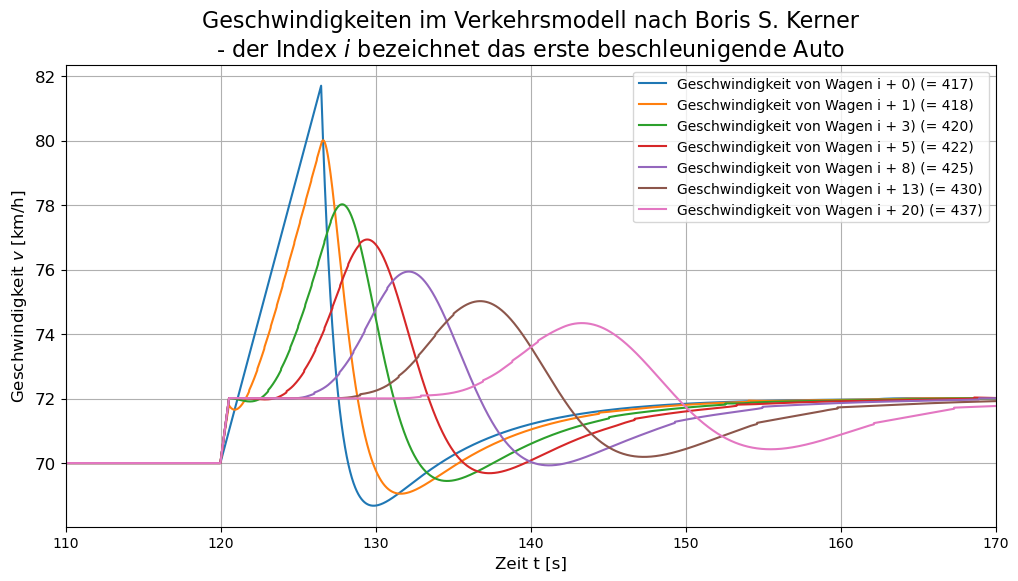

In [9]:
Startzeit = now()
println("Startzeit = $Startzeit")

###############################################################################################
### hier habe wieder einfügen
###############################################################################################
Wagennummern = break_guy1 ; 
println("Wagennummern = $Wagennummern")
#w1 = Wagennummern1 + 1
#w2 = w1 + 5
#w3 = w1 + 7
#w4 = w3 + 6
#Wagennummern2 = w1:w2 ; Wagennummern3 = w3:w4
#Wagennummern1ar = collect(Wagennummern1) ; Wagennummern2ar = collect(Wagennummern2)
#Wagennummern3ar = collect(Wagennummern3)

#Wagennummern_ar = vcat(Wagennummern1ar, Wagennummern2ar)#, Wagennummern3ar)

Verschiebungsvektor = [1,2,4,6, 9,14,21]
#Verschiebungsvektor = [1,2,4,7,10,14,19]
Wagennummern_ar = Verschiebungsvektor .+(Wagennummern - 1)
println("length(Wagennummern_ar) = $(length(Wagennummern_ar))")
println("Wagennummern_ar = $Wagennummern_ar")

###############################################################################################
### Plot
###############################################################################################

figure(figsize=(12,6))
for (i,Wn) in enumerate(Wagennummern_ar) #movement_Index_numbers
    plot(movement_vec[Wn][1] , 3.6*movement_vec[Wn][3] , linestyle="-",
        label="Geschwindigkeit von Wagen i + $(Wn-Wagennummern)) (= $Wn)"
    )
#, color="tab:blue") 
end

xlabel("Zeit t [s]", loc="center",fontsize=12)
ylabel("Geschwindigkeit "*L"v"*" [km/h]",fontsize=12)

#xticks(110:5:175, fontsize=12)  # Größe der x-Achsen-Ticklabels
yticks(fontsize=12)  # Größe der y-Achsen-Ticklabels
xlim([110.0, 170.0])
##xlim([190.0, 220.0])
#ylim([90.0, 115.0])
grid(true)
legend()
title("Geschwindigkeiten im Verkehrsmodell nach Boris S. Kerner
- der Index "*L"i"*" bezeichnet das erste beschleunigende Auto",fontsize=16)

Zielzeit = now()
println("Endzeit   = $Zielzeit")
#savefig("C:/Users/Fliese/Desktop/Kerner-Modell/jupyter notebooks Kerner-Modell/Bilder Figure 3/Geschwindigkeitsverteilung nach dem Beschleuniger mit Δt_a = $break_time1_input s.svg",
#    bbox_inches="tight")
#savefig("C:/Users/Fliese/Desktop/Kerner-Modell/jupyter notebooks Kerner-Modell/Bilder Figure 3/Geschwindigkeitsverteilung nach dem Beschleuniger mit Δt_a = $break_time1_input s.png",
#    bbox_inches="tight")


In [21]:
0.5*6.5*3.6 , 0.5*7.0*3.6

(11.700000000000001, 12.6)

Startzeit = 2024-08-24T15:22:56.741
Endzeit   = 2024-08-24T15:22:56.983


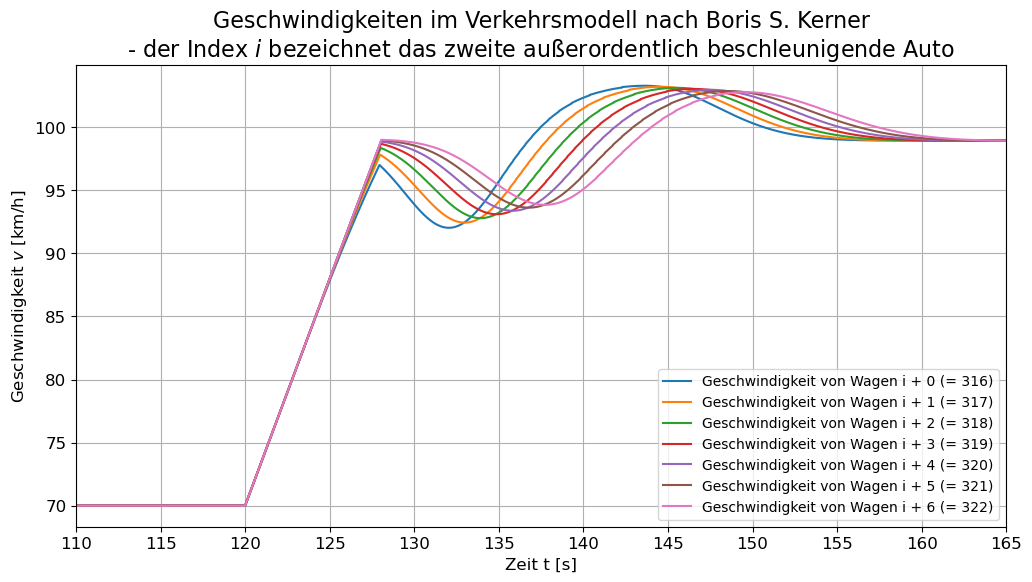

In [22]:
Startzeit = now()
println("Startzeit = $Startzeit")

###############################################################################################
### hier habe wieder einfügen
###############################################################################################
Wagennummern1 = break_guy2 ; 
w1 = Wagennummern1 + 1
w2 = w1 + 5
w3 = w1 + 7
w4 = w3 + 6
Wagennummern2 = w1:w2 ; Wagennummern3 = w3:w4
Wagennummern1ar = collect(Wagennummern1) ; Wagennummern2ar = collect(Wagennummern2)
Wagennummern3ar = collect(Wagennummern3)

Wagennummern_ar = vcat(Wagennummern1ar, Wagennummern2ar)#, Wagennummern3ar)

###############################################################################################
### Plot
###############################################################################################

figure(figsize=(12,6))
for i in Wagennummern_ar #movement_Index_numbers
    plot(movement_vec[i][1] , 3.6*movement_vec[i][3] , linestyle="-",
        label="Geschwindigkeit von Wagen i + $(Wagennummern_ar[i+1-Wagennummern1]-Wagennummern1) (= $i)")
#, color="tab:blue") 
end

xlabel("Zeit t [s]", loc="center",fontsize=12)
ylabel("Geschwindigkeit "*L"v"*" [km/h]",fontsize=12)

xticks(110:5:175, fontsize=12)  # Größe der x-Achsen-Ticklabels
yticks(fontsize=12)  # Größe der y-Achsen-Ticklabels
xlim([110.0, 165.0])
##xlim([190.0, 220.0])
##ylim([5.0, 15.0])
grid(true)
legend()
title("Geschwindigkeiten im Verkehrsmodell nach Boris S. Kerner
- der Index "*L"i"*" bezeichnet das zweite außerordentlich beschleunigende Auto",fontsize=16)

Zielzeit = now()
println("Endzeit   = $Zielzeit")
#savefig("C:/Users/Fliese/Desktop/Kerner-Modell/jupyter notebooks Kerner-Modell/Bilder Figure 3/Geschwindigkeitsverteilung nach dem Beschleuniger mit Δt_a = $break_time2_input s.svg",
#    bbox_inches="tight")
#savefig("C:/Users/Fliese/Desktop/Kerner-Modell/jupyter notebooks Kerner-Modell/Bilder Figure 3/Geschwindigkeitsverteilung nach dem Beschleuniger mit Δt_a = $break_time2_input s.png",
#    bbox_inches="tight")


In [74]:
Ar = [1, 3]
println("Diese Elemente liegen in Ar")
for i in 1:4
    if i in Ar
        println(i)
    end
end
println("Diese Elemente liegen nicht in Ar")
for i in 1:4
    if !(i in Ar)
        println(i)
    end
end        

Diese Elemente liegen in Ar
1
3
Diese Elemente liegen nicht in Ar
2
4


Startzeit = 2024-01-14T12:19:09.301
Endzeit   = 2024-01-14T12:19:23.944


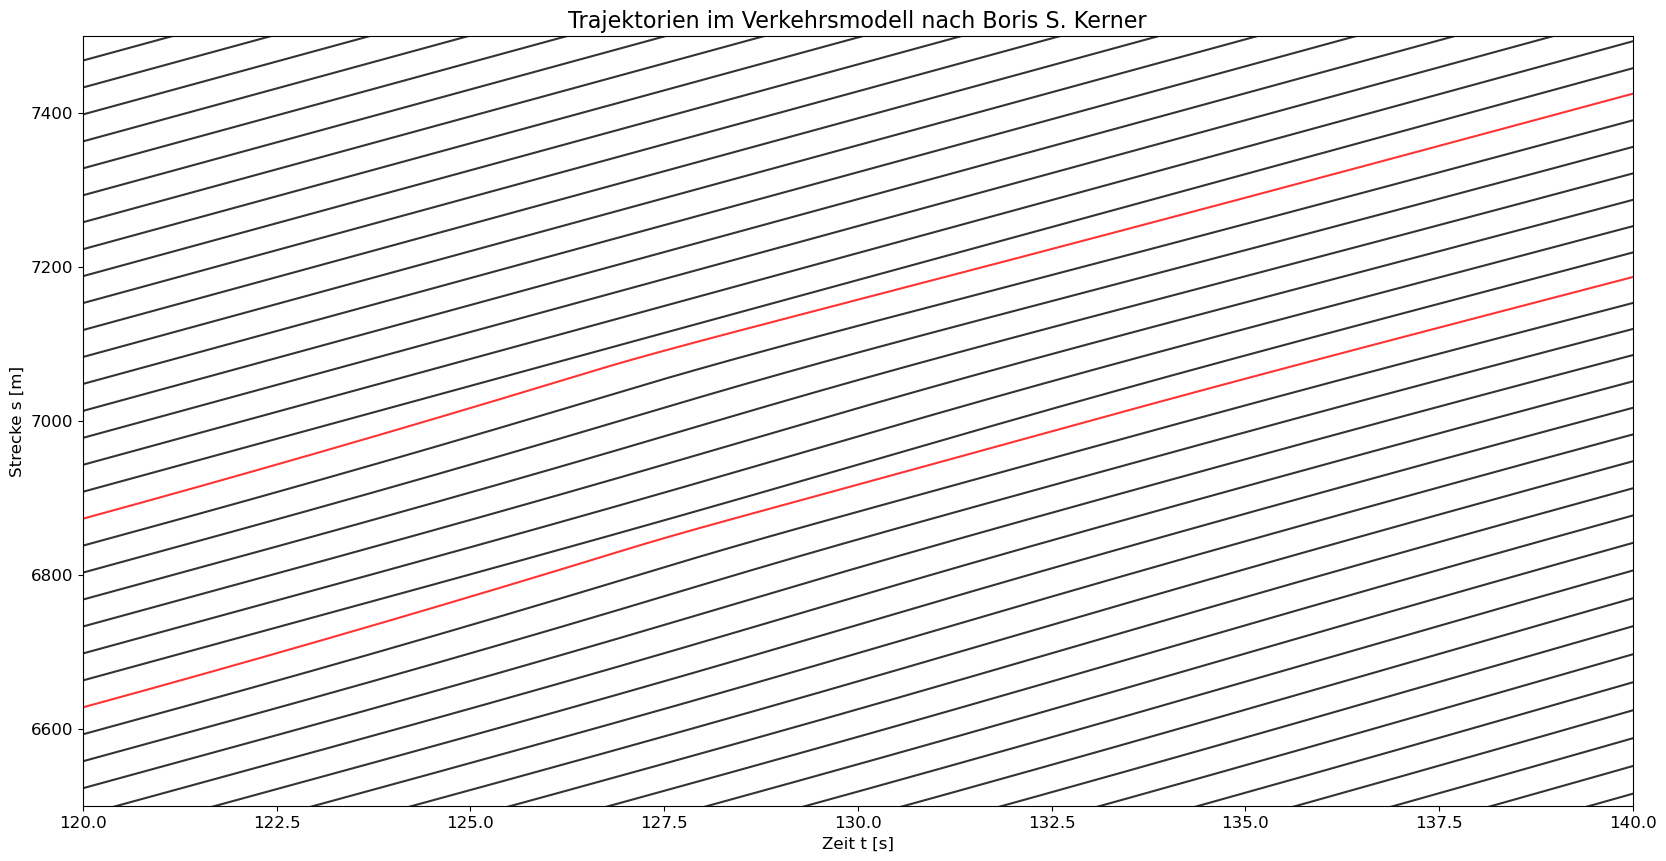

In [25]:
Startzeit = now()
println("Startzeit = $Startzeit")

ns_breaking_guys = [n_the_breaking_guy1_export, n_the_breaking_guy2_export]

figure(figsize=(20,10))

for i in movement_Index_numbers
    if !(i in ns_breaking_guys)
        plot(movement_vec[i][1] , movement_vec[i][2] , label="$i", color="k", alpha=0.8)
    end
end

for i in ns_breaking_guys
    plot(movement_vec[i][1] , movement_vec[i][2] , label="$i", color="r", alpha=0.8)
end

xlabel("Zeit t [s]", loc="center",fontsize=12)
ylabel("Strecke s [m]",fontsize=12)

xticks(fontsize=12)  # Größe der x-Achsen-Ticklabels
yticks(fontsize=12)  # Größe der y-Achsen-Ticklabels

xlim([120, 140])
ylim([6500, 7500])
#xlim([100, 150])
#xlim([100, 200])
#ylim([0, 1600])

#ylim([0, 4000])
#legend()
title("Trajektorien im Verkehrsmodell nach Boris S. Kerner",fontsize=16)
#savefig("C:/Users/Fliese/Desktop/Master-Arbeit/Kerner-Modell/Bilder/Trajektorien für den Beschleuniger mit Δt_a = $break_time_input s.svg", bbox_inches="tight")

Zielzeit = now()
println("Endzeit   = $Zielzeit")

In [60]:
# v_min definieren !!!

In [61]:
#using PyPlot

Startzeit = 2024-01-16T01:22:41.891
Endzeit   = 2024-01-16T01:22:54.082


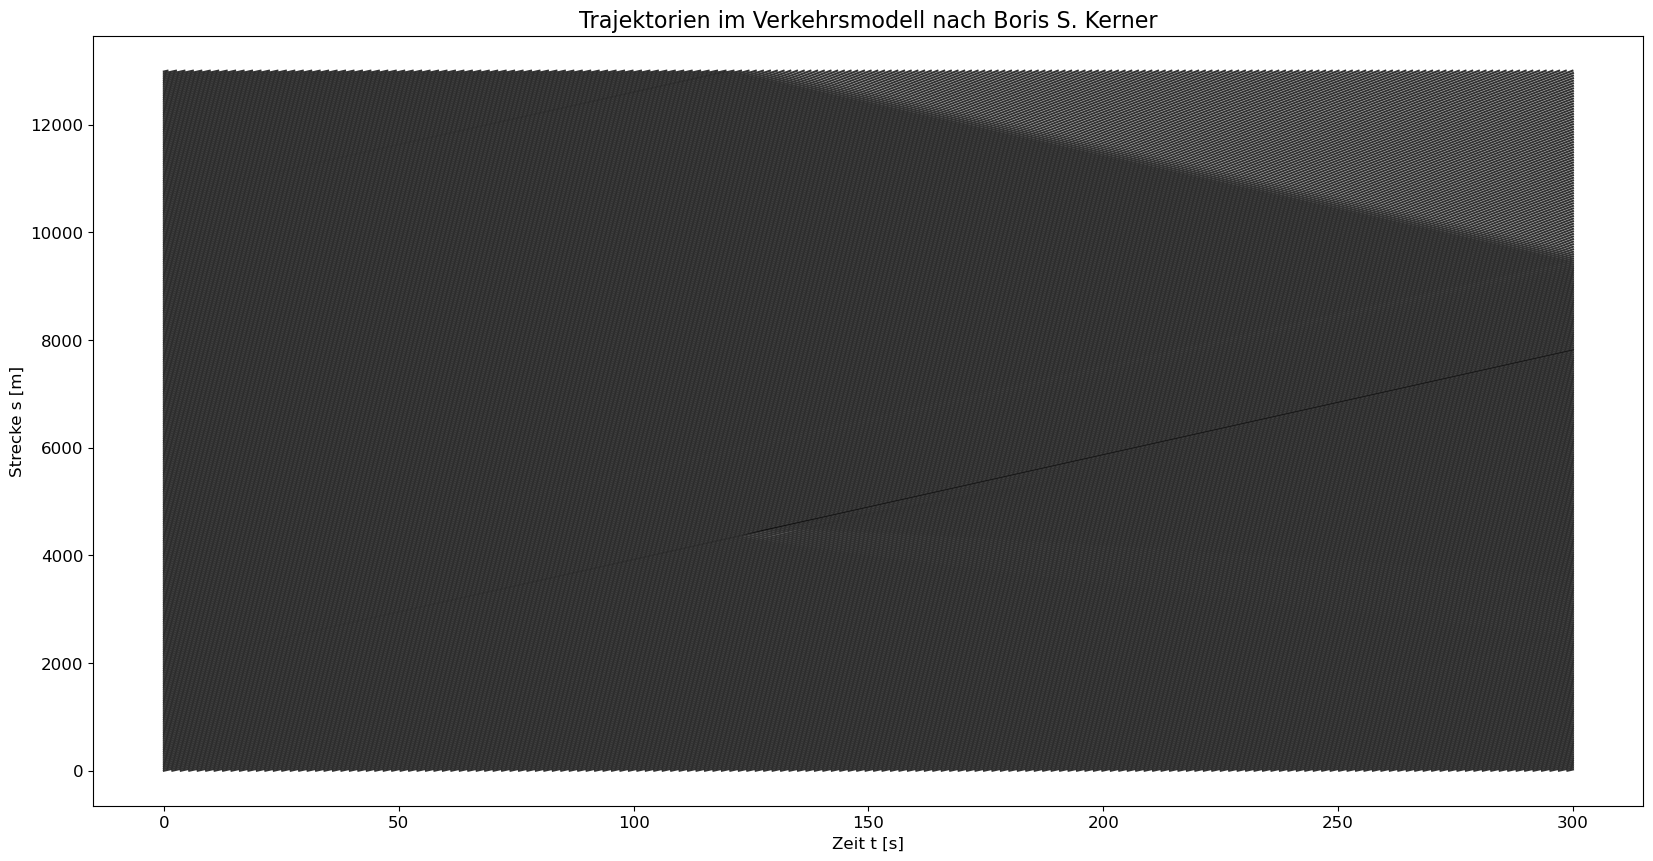

In [50]:
Startzeit = now()
println("Startzeit = $Startzeit")

figure(figsize=(20,10))
#
#for i in movement_Index_numbers
#    plot(movement_vec[i][2] , movement_vec[i][3], color="k")
#end

for i in movement_Index_numbers # 1:1
    plot(movement_vec[i][1] , movement_vec[i][2] , label="$i", color="k", alpha=0.8)
end

xlabel("Zeit t [s]", loc="center",fontsize=12)
ylabel("Strecke s [m]",fontsize=12)

xticks(fontsize=12)  # Größe der x-Achsen-Ticklabels
yticks(fontsize=12)  # Größe der y-Achsen-Ticklabels
#xlim([100, 300])
#ylim([7000, 8000])
#xlim([110, 300])
#ylim([1000, 2500])
#legend()
title("Trajektorien im Verkehrsmodell nach Boris S. Kerner",fontsize=16)
#savefig("C:/Users/Fliese/Desktop/Master-Arbeit/Kerner-Modell/Bilder/Trajektorien 1.svg", bbox_inches="tight")

Zielzeit = now()
println("Endzeit   = $Zielzeit")

In [61]:
if 3 in collect(1:5)
    println("ja")
end

ja


Startzeit = 2024-01-16T02:01:49.267
Endzeit   = 2024-01-16T02:02:04.072


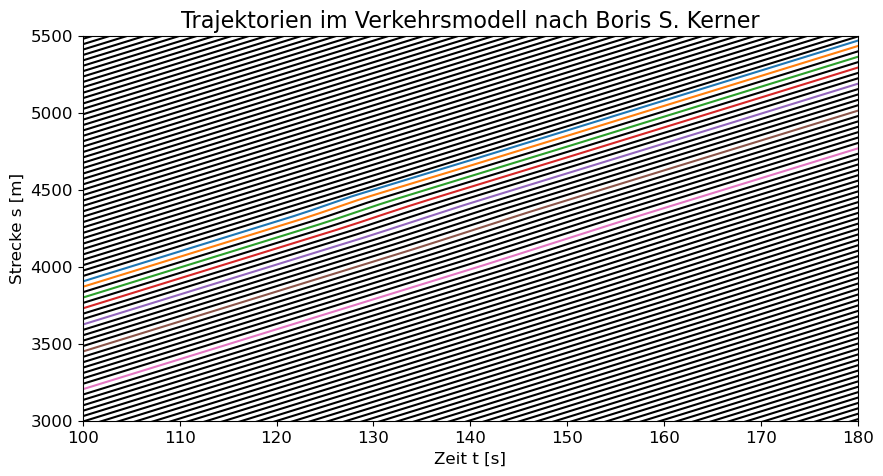

In [20]:
Startzeit = now()
println("Startzeit = $Startzeit")

figure(figsize=(10,5))
for i in movement_Index_numbers # 1:1
    if !(i in Wagennummern_ar)
        plot(movement_vec[i][1] , movement_vec[i][2] , label="$i", color="k", alpha=1.0) #0.5
    elseif i in Wagennummern_ar
        plot(movement_vec[i][1] , movement_vec[i][2] , label="$i", alpha=1.0)
    end
end

#for (i,Wn) in enumerate(Wagennummern_ar) #movement_Index_numbers
#    plot(movement_vec[Wn][1] , movement_vec[Wn][2] , label="$Wn", color="r", alpha=1.0)
#end

xlabel("Zeit t [s]", loc="center",fontsize=12)
ylabel("Strecke s [m]",fontsize=12)

xticks(fontsize=12)  # Größe der x-Achsen-Ticklabels
yticks(fontsize=12)  # Größe der y-Achsen-Ticklabels

xlim([100, 180]) ; ylim([3000, 5500])

title("Trajektorien im Verkehrsmodell nach Boris S. Kerner",fontsize=16)

#savefig("C:/Users/Fliese/Desktop/Kerner-Modell/jupyter notebooks Kerner-Modell/Bilder Figure 3/Trajektorien Überbeschl2.svg",
#    bbox_inches="tight")
#savefig("C:/Users/Fliese/Desktop/Kerner-Modell/jupyter notebooks Kerner-Modell/Bilder Figure 3/Trajektorien Überbeschl2.png",
#    bbox_inches="tight")

Zielzeit = now()
println("Endzeit   = $Zielzeit")

In [78]:
n_the_breaking_guy1_export , n_the_breaking_guy2_export

(323, 330)

In [79]:
# kritschen Zeitpunkt und Ort der initialen Bremsung/Beschleunigung finden
index = 0
for i in 1:length(movement_vec[n_the_breaking_guy1_export][1])
    if movement_vec[n_the_breaking_guy1_export][1][i] ≥ t_break1_input
        index = i
        break
    end
end        
    
#index = 4000
movement_vec[n_the_breaking_guy1_export][1][index] , movement_vec[n_the_breaking_guy1_export][2][index]

(120.0, 1038.3812529277805)

Startzeit = 2024-01-14T12:20:31.041
Endzeit   = 2024-01-14T12:20:47.116


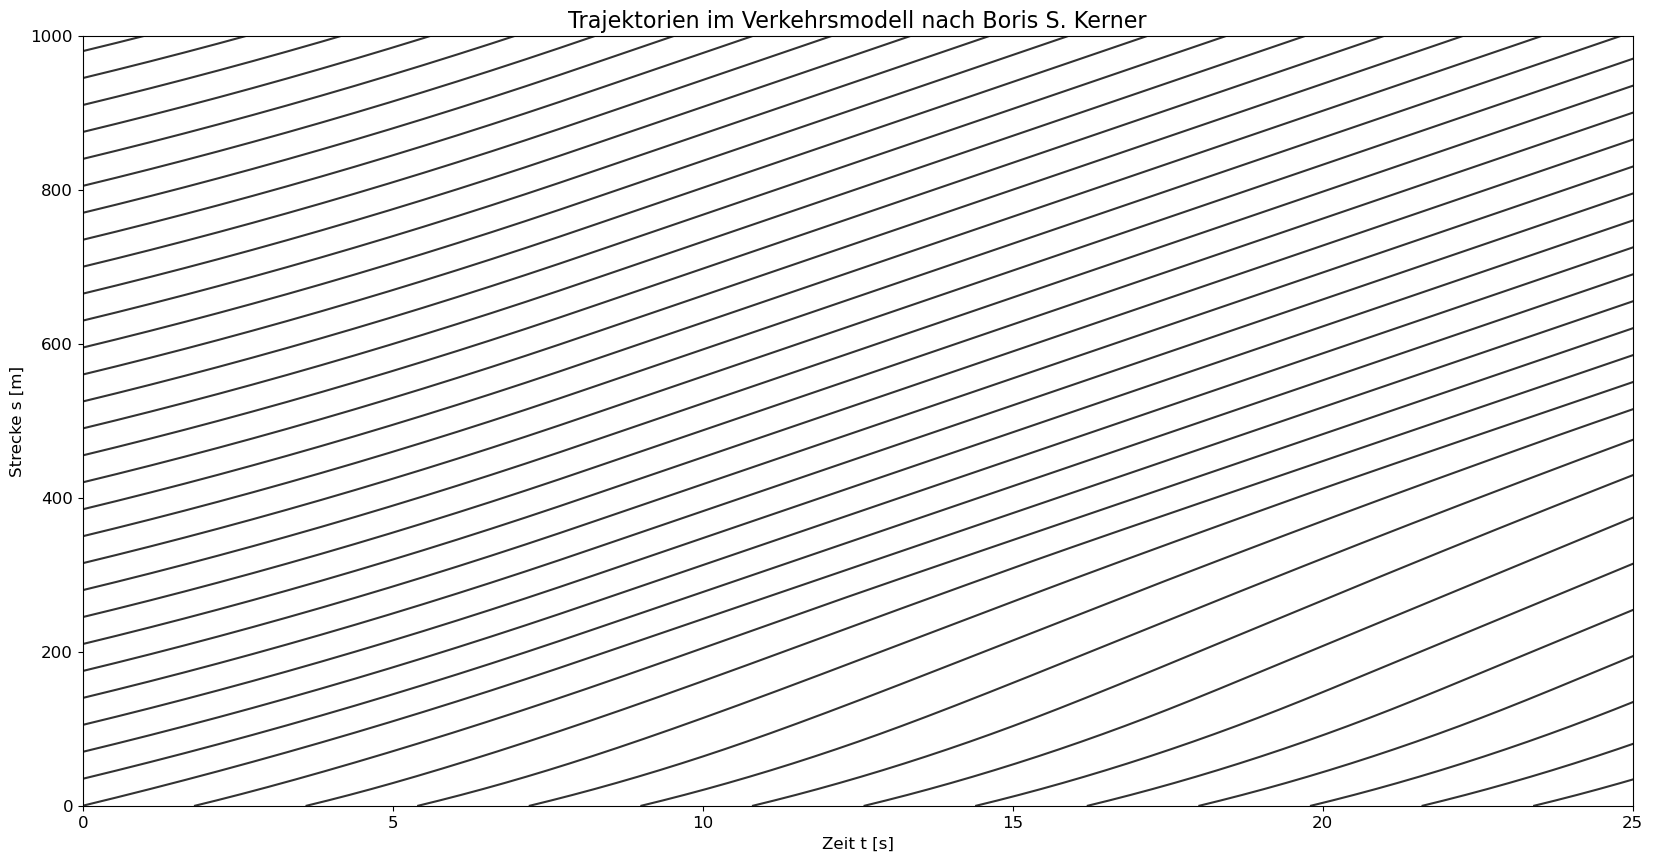

In [26]:
Startzeit = now()
println("Startzeit = $Startzeit")

figure(figsize=(20,10))
#=
for i in movement_Index_numbers
    plot(movement_vec[i][1] , movement_vec[i][2], color="k")
end
=#
for i in movement_Index_numbers # 1:1
    if i ≠ n_the_breaking_guy1_export || i ≠ n_the_breaking_guy2_export
        plot(movement_vec[i][1] , movement_vec[i][2] , label="$i", color="k", alpha=0.8)
    end
end
for i in ns_breaking_guys
    plot(movement_vec[i][1] , movement_vec[i][2] , label="$i", color="r", alpha=0.8)
end

xlabel("Zeit t [s]", loc="center",fontsize=12)
ylabel("Strecke s [m]",fontsize=12)

xticks(fontsize=12)  # Größe der x-Achsen-Ticklabels
yticks(fontsize=12)  # Größe der y-Achsen-Ticklabels

#xlim([100, 300])
#xlim([100, 150])
xlim([0, 25])
#ylim([0, 1600])
#ylim([0, 2000])
ylim([0, 1000])
#legend()
title("Trajektorien im Verkehrsmodell nach Boris S. Kerner",fontsize=16)
#savefig("C:/Users/Fliese/Desktop/Master-Arbeit/Kerner-Modell/Bilder/Trajektorien für den Beschleuniger mit Δt_a = $break_time1_input s.svg", bbox_inches="tight")

Zielzeit = now()
println("Endzeit   = $Zielzeit")

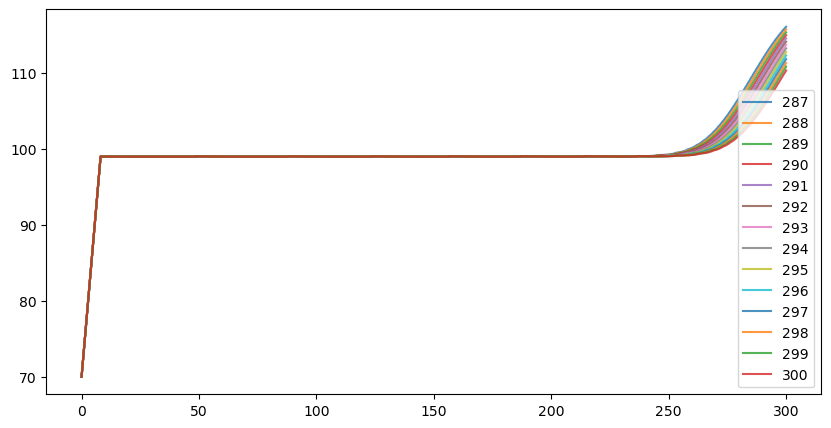

PyObject <matplotlib.legend.Legend object at 0x000001322F602380>

In [49]:
figure(figsize=(10,5))

for i in 287:300#310
    plot(movement_vec[i][1] , 
        3.6*movement_vec[i][3] , label="$i",
        #color="k",
        alpha=0.8)
end
first_index_to_plot = 287
#plot(movement_vec[first_index_to_plot][1] , 3.6*movement_vec[first_index_to_plot][3] , label="$first_index_to_plot",
#color="tab:blue", alpha=0.8)

legend()
#xlim([0, 25])
#ylim([0, 1000])

In [40]:
length(movement_vec)

452

In [41]:
length(movement_vec[50][1])

7765

In [124]:
#movement_vec[452][3]

Startzeit = 2024-01-08T13:40:44.938
Endzeit = 2024-01-08T13:40:45.880


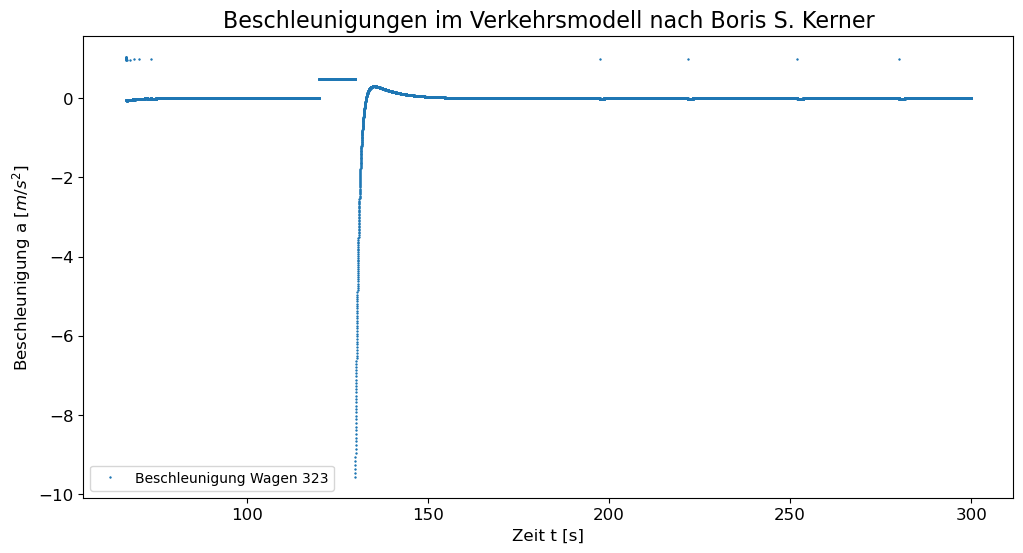

In [42]:
Startzeit = now()
println("Startzeit = $Startzeit")

figure(figsize=(12,6))

 
for plot_Index in break_guy1:break_guy1 #movement_Index_numbers
#plot_Index = 15
plot(movement_vec[plot_Index][1] , movement_vec[plot_Index][4], 
    "+", markersize= 1.8,
label="Beschleunigung Wagen $plot_Index")#, color="tab:orange")
#plot(movement_vec_vel[plot_Index][2] , movement_vec_vel[plot_Index][3] , linestyle="-",
#label="Geschwindigkeit Wagen $(movement_vec[plot_Index][1])", color="tab:blue")

end

xlabel("Zeit t [s]", loc="center",fontsize=12)
ylabel("Beschleunigung a "*L"[m/s^2]",fontsize=12)

xticks(fontsize=12)  # Größe der x-Achsen-Ticklabels
yticks(fontsize=12)  # Größe der y-Achsen-Ticklabels
#xlim([15.0,16.0])

legend()
title("Beschleunigungen im Verkehrsmodell nach Boris S. Kerner",fontsize=16)

Zielzeit = now()
println("Endzeit = $Zielzeit")

In [43]:
testvec = [1,2,3]
testvec .+ 3

3-element Vector{Int64}:
 4
 5
 6

In [45]:
break_guy1

323

In [46]:
n_the_breaking_guy1_export

323

In [47]:
# Breaker und auto davor "synchronisieren" -> Auf gleiche Zeiten bringen

car_before_breaker1 = deepcopy(movement_vec[n_the_breaking_guy1_export - 1])
movement_breaker1   = deepcopy(movement_vec[n_the_breaking_guy1_export])

len1_t_0  = length(car_before_breaker1[1])
len1_t_1  = length(movement_breaker1[1])
time_diff_low1  = movement_breaker1[1][1] - car_before_breaker1[1][1]
time_diff_high1 = movement_breaker1[1][len1_t_1] - car_before_breaker1[1][len1_t_0]

n_to_cut_from_car_before_breaker1 = Int64(round(time_diff_low1 / t_step_input)) ;
n_to_cut_from_movement_breaker1   = Int64(round(time_diff_high1 / t_step_input))

    
for i in 1: n_to_cut_from_car_before_breaker1
    deleteat!(car_before_breaker1[1],1)
    deleteat!(car_before_breaker1[2],1)
    deleteat!(car_before_breaker1[3],1)
    deleteat!(car_before_breaker1[4],1)
end
for i in 1: n_to_cut_from_movement_breaker1
    pop!(movement_breaker1[1])
    pop!(movement_breaker1[2])
    pop!(movement_breaker1[3])
    pop!(movement_breaker1[4])
end
#plot(movement_breaker[1],movement_breaker[2]) ; plot(car_before_breaker[1],car_before_breaker[2])
g_breaker1  = (movement_breaker1[1] , movement_breaker1[1] , car_before_breaker1[2] - movement_breaker1[2] .- d_par_input)
Δv_breaker1 = (movement_breaker1[1] , movement_breaker1[1] , car_before_breaker1[3] - movement_breaker1[3])

v_vec_breaker1  = deepcopy(movement_vec[n_the_breaking_guy1_export])
g_safe_barrier1 = [v_vec_breaker1[1], v_vec_breaker1[1], τ_safe_input * v_vec_breaker1[3]]
G_barrier1      = [v_vec_breaker1[1], v_vec_breaker1[1], τ_G_input    * v_vec_breaker1[3]]
1+1

2

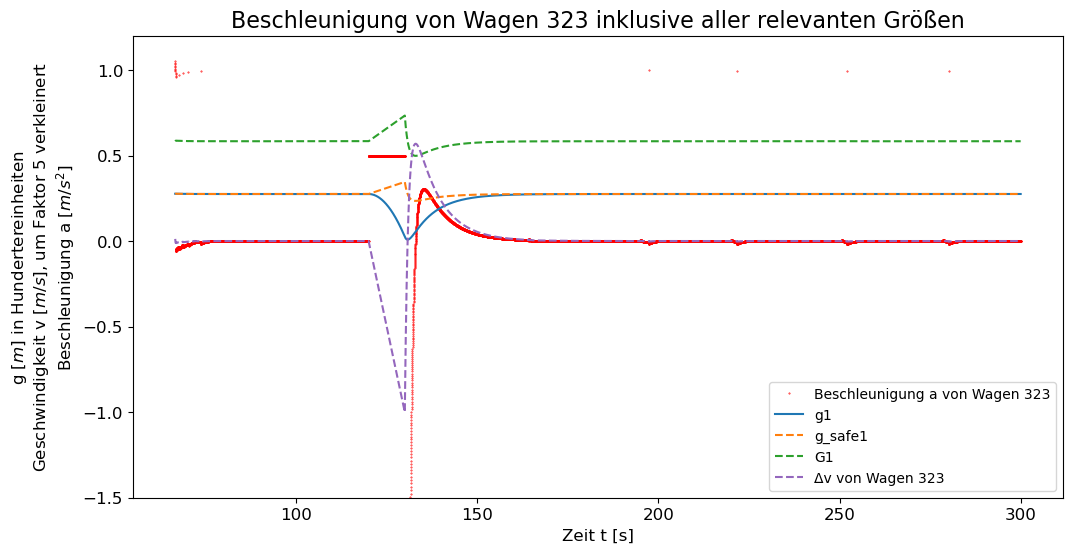

PyObject Text(0.5, 1.0, 'Beschleunigung von Wagen 323 inklusive aller relevanten Größen')

In [49]:
figure(figsize=(12,6)) #4,2
plot(movement_vec[break_guy1][1] , movement_vec[break_guy1][4], 
#"-",label="Beschleunigung a von Wagen $n_the_breaking_guy1_export", color="r")    
".",markersize="0.8" ,label="Beschleunigung a von Wagen $n_the_breaking_guy1_export", color="r")
    
plot(g_breaker1[2]      , g_breaker1[3] / 100    ,"-" ,label="g1"                , color="tab:blue")
plot(g_safe_barrier1[2] , g_safe_barrier1[3] /100,"--",label="g_safe1"           , color="tab:orange")
plot(G_barrier1[2]      , G_barrier1[3] /100     ,"--",label="G1"                , color="tab:green")

plot(Δv_breaker1[2]     , Δv_breaker1[3] / 5     ,"--",label="Δv von Wagen $n_the_breaking_guy1_export",color="tab:purple")

xlabel("Zeit t [s]", loc="center",fontsize=12) ; ylabel("g "*L"[m]"*" in Hundertereinheiten\nGeschwindigkeit v "*L"[m/s]"
*", um Faktor 5 verkleinert"
*"\nBeschleunigung a "*L"[m/s^2]" ,fontsize=12)

xticks(fontsize=12) ; yticks(fontsize=12)
#xlim([180.0,220.0]) ;
#ylim([0, 1.5])
ylim([-1.5, 1.2])

legend()#(loc="center")
title("Beschleunigung von Wagen $break_guy1 inklusive aller relevanten Größen",fontsize=16)
#savefig("C:/Users/Fliese/Desktop/Master-Arbeit/Kerner-Modell/Bilder/Beschleunigung des Bremsers 2.svg", bbox_inches="tight")

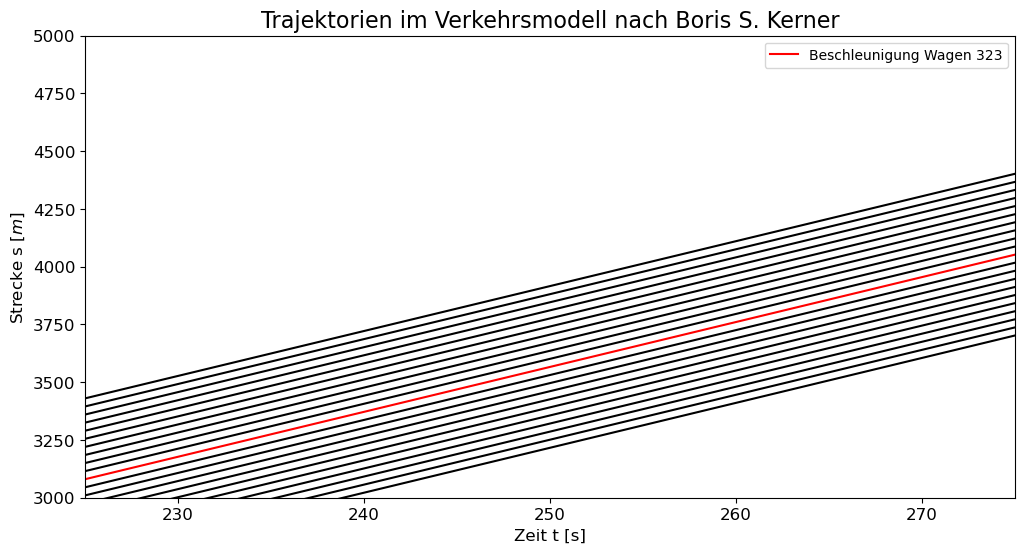

PyObject Text(0.5, 1.0, 'Trajektorien im Verkehrsmodell nach Boris S. Kerner')

In [131]:
figure(figsize=(12,6))
for plot_Index in (break_guy - 10) : (break_guy + 10) #movement_Index_numbers
    if plot_Index ≠ break_guy
        plot(movement_vec[plot_Index][1] , movement_vec[plot_Index][2], 
        "-",
        #linestyle="-",
        color="k")#, color="tab:orange")
    end    
end
plot(movement_vec[break_guy][1] , movement_vec[break_guy][2], "-", label="Beschleunigung Wagen $break_guy", color="r")

xlabel("Zeit t [s]", loc="center",fontsize=12) ; ylabel("Strecke s "*L"[m]",fontsize=12)

xticks(fontsize=12) ; yticks(fontsize=12)
xlim([225.0,275.0]) ; ylim([3000, 5000])
legend()
title("Trajektorien im Verkehrsmodell nach Boris S. Kerner",fontsize=16)

In [132]:
besip = [1,2,3,4]
deleteat!(besip,2)

3-element Vector{Int64}:
 1
 3
 4

In [134]:
# Hat hier alles geklappt ??? Benjamin Blümchen
time_1 = 225
time_2 = 275
central_car = break_guy
observed_cars_area = 10
first_observed_car = central_car - observed_cars_area
last_observed_car  = central_car + observed_cars_area
n_observed_cars    = 2 * observed_cars_area + 1

observed_cars_movement_vec = deepcopy(movement_vec)
for car_number in 1 : new_car_number_export
    backrun_Index = new_car_number_export + 1 - car_number
    pop!(observed_cars_movement_vec[backrun_Index]) # Wagennummer entfernen
    pop!(observed_cars_movement_vec[backrun_Index]) # Beschleunigungswerte entfernen
    pop!(observed_cars_movement_vec[backrun_Index]) # geschwindigkeitswerte entfernen
    if backrun_Index > last_observed_car
        deleteat!(observed_cars_movement_vec, backrun_Index)
    elseif backrun_Index < first_observed_car
        deleteat!(observed_cars_movement_vec, backrun_Index)
    end
end

last_t_Index = Int64(round(t_end_input/t_step_input)+1)
for car_number in first_observed_car : last_observed_car
    car_Index = car_number + 1 - first_observed_car
    for time_Index in 1 : last_t_Index
        time_backrun_Index = last_t_Index + 1 - time_Index
        if time_backrun_Index ≤ length(observed_cars_movement_vec[car_Index][1]) 

            if observed_cars_movement_vec[car_Index][1][time_backrun_Index] > time_2
                deleteat!(observed_cars_movement_vec[car_Index][1],time_backrun_Index)
                deleteat!(observed_cars_movement_vec[car_Index][2],time_backrun_Index)
            elseif observed_cars_movement_vec[car_Index][1][time_backrun_Index] < time_1
                deleteat!(observed_cars_movement_vec[car_Index][1],time_backrun_Index)
                deleteat!(observed_cars_movement_vec[car_Index][2],time_backrun_Index)
            end
        end
    end
end

len_t = Int64(round( (time_2 - time_1) / t_step_input)) +1
standard_mover = []
for time in 1: len_t
    push!(standard_mover, v_syn_input * time * t_step_input)
end

In [135]:
len_t

5001

In [136]:
for car_Index in 1:21
    #println(length(observed_cars_movement_vec[car_Index][2]))
    #println(observed_cars_movement_vec[car_Index][2][1])
end

In [137]:
#println(observed_cars_movement_vec[1])

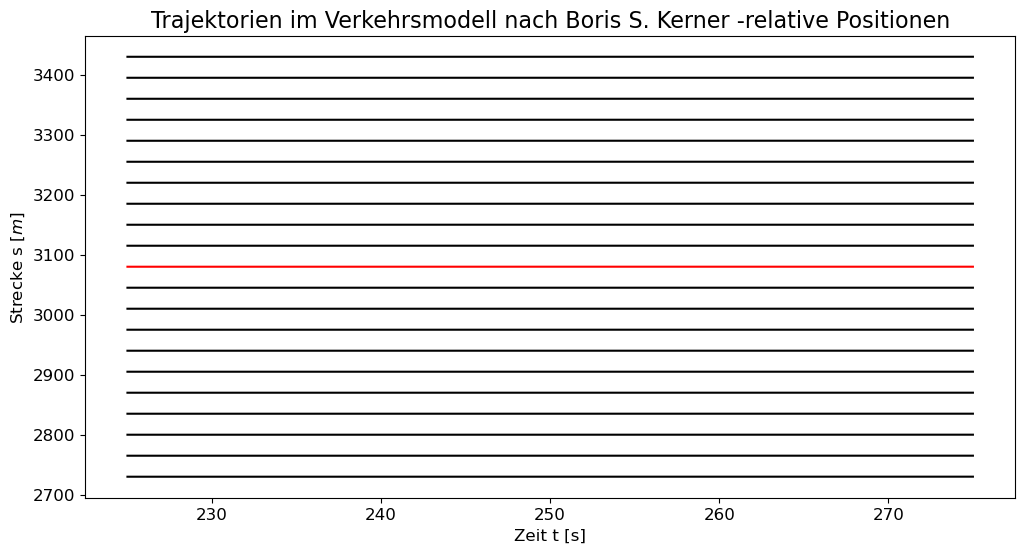

PyObject Text(0.5, 1.0, 'Trajektorien im Verkehrsmodell nach Boris S. Kerner -relative Positionen')

In [138]:

figure(figsize=(12,6))
for car_number in first_observed_car : (central_car-1)
    #car_number = plot_Index + first_observed_car - 1
    plot_Index = car_number + 1 - first_observed_car
    plot(observed_cars_movement_vec[plot_Index][1] , observed_cars_movement_vec[plot_Index][2] - standard_mover, 
    "-",
    #linestyle="-",
    label="Beschleunigung Wagen $car_number", color="k")#, color="tab:orange")
end

car_Index_in_vec = observed_cars_area + 1
plot(observed_cars_movement_vec[car_Index_in_vec][1] , observed_cars_movement_vec[car_Index_in_vec][2] - standard_mover,
"-", label="Beschleunigung Wagen $central_car", color="r")#, color="tab:orange")

for car_number in (central_car+1) : last_observed_car
    #car_number = plot_Index + first_observed_car - 1
    plot_Index = car_number + 1 - first_observed_car
    plot(observed_cars_movement_vec[plot_Index][1] , observed_cars_movement_vec[plot_Index][2] - standard_mover, 
    "-",
    #linestyle="-",
    label="Beschleunigung Wagen $car_number", color="k")#, color="tab:orange")
end



xlabel("Zeit t [s]", loc="center",fontsize=12) ; ylabel("Strecke s "*L"[m]",fontsize=12)

xticks(fontsize=12) ; yticks(fontsize=12)
#xlim([225.0,275.0]) ; #ylim([3000, 5000])
#legend()
title("Trajektorien im Verkehrsmodell nach Boris S. Kerner -relative Positionen",fontsize=16)

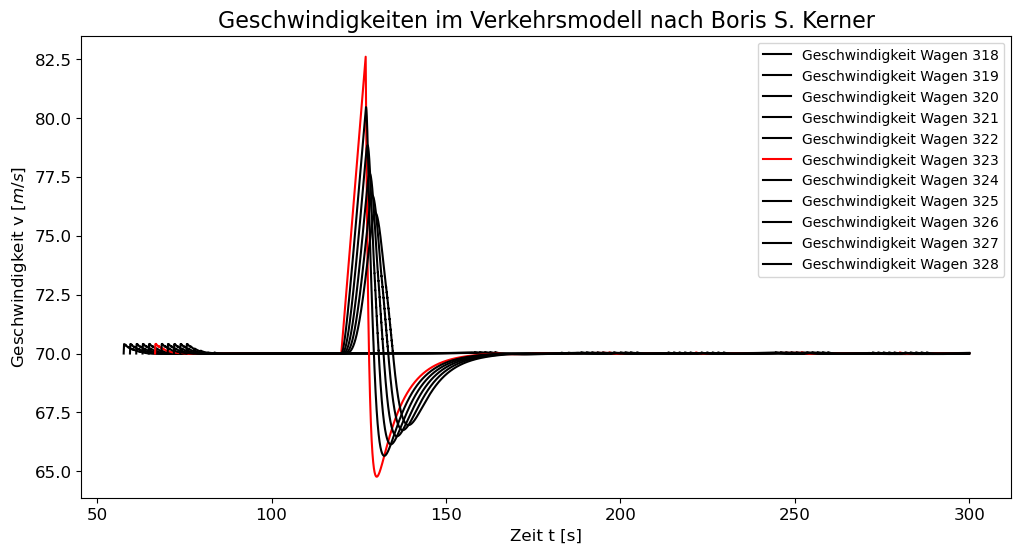

PyObject Text(0.5, 1.0, 'Geschwindigkeiten im Verkehrsmodell nach Boris S. Kerner')

In [139]:
figure(figsize=(12,6))
for plot_Index in (break_guy - 5) : (break_guy - 1) #movement_Index_numbers
    if plot_Index ≠ break_guy
        plot(movement_vec[plot_Index][1] , 3.6*movement_vec[plot_Index][3], 
        "-",
        #linestyle="-",
        label="Geschwindigkeit Wagen $plot_Index", color="k")#, color="tab:orange")
    end    
end
plot(movement_vec[break_guy][1] , 3.6* movement_vec[break_guy][3], "-", label="Geschwindigkeit Wagen $break_guy", color="r")

for plot_Index in (break_guy + 1) : (break_guy + 5) #movement_Index_numbers
    if plot_Index ≠ break_guy
        plot(movement_vec[plot_Index][1] , 3.6*movement_vec[plot_Index][3], 
        "-",
        #linestyle="-",
        label="Geschwindigkeit Wagen $plot_Index", color="k")#, color="tab:orange")
    end
end

xlabel("Zeit t [s]", loc="center",fontsize=12) ; ylabel("Geschwindigkeit v "*L"[m/s]",fontsize=12)

xticks(fontsize=12) ; yticks(fontsize=12)
#xlim([225.0, 275.0]) ; ylim([65, 80])
legend()
title("Geschwindigkeiten im Verkehrsmodell nach Boris S. Kerner",fontsize=16)

Startzeit = 2024-01-07T00:54:02.658
Endzeit   = 2024-01-07T00:54:02.908


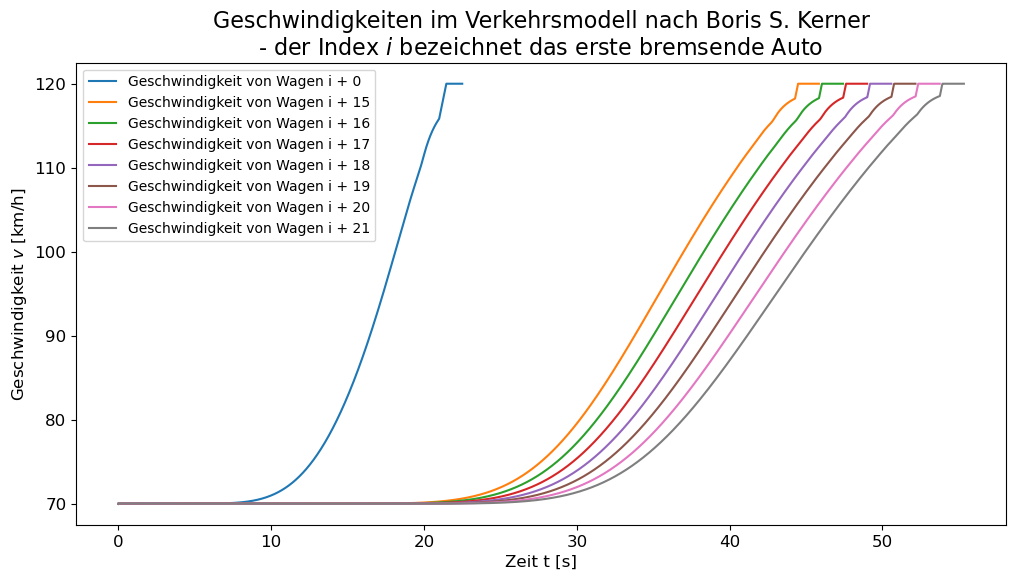

In [140]:
Startzeit = now()
println("Startzeit = $Startzeit")

figure(figsize=(12,6))

Wagennummern1 = 14:16 ; 
Wagennummern1 = 15:15 ; 

Wagennummern2 = 30:36 ; Wagennummern3 = 50:56
Wagennummern1ar = collect(Wagennummern1) ; Wagennummern2ar = collect(Wagennummern2)
Wagennummern3ar = collect(Wagennummern3)

Wagennummern_ar = vcat(Wagennummern1ar, Wagennummern2ar)#, Wagennummern3ar)
 
for i in Wagennummern_ar #movement_Index_numbers
    plot(movement_vec[i][1] , 3.6*movement_vec[i][3] ,
    linestyle="-", label="Geschwindigkeit von Wagen i + $(movement_vec[i][5]-15)")#, color="tab:blue")
end

xlabel("Zeit t [s]", loc="center",fontsize=12)
ylabel("Geschwindigkeit "*L"v"*" [km/h]",fontsize=12)

xticks(fontsize=12)  # Größe der x-Achsen-Ticklabels
yticks(fontsize=12)  # Größe der y-Achsen-Ticklabels
#xlim([110.0, 250.0])
##xlim([190.0, 220.0])
##ylim([5.0, 15.0])

legend()
title("Geschwindigkeiten im Verkehrsmodell nach Boris S. Kerner
- der Index "*L"i"*" bezeichnet das erste bremsende Auto",fontsize=16)

Zielzeit = now()
println("Endzeit   = $Zielzeit")

In [ ]:
Benjenbenjen

In [ ]:
Startzeit = now()
println("Startzeit = $Startzeit")



Wagennummern1 = break_guy ; 
w1 = Wagennummern1 + 1
w2 = w1 + 5
w3 = w1 + 7
w4 = w3 + 6
Wagennummern2 = w1:w2 ; Wagennummern3 = w3:w4
Wagennummern1ar = collect(Wagennummern1) ; Wagennummern2ar = collect(Wagennummern2)
Wagennummern3ar = collect(Wagennummern3)

Wagennummern_ar = vcat(Wagennummern1ar, Wagennummern2ar)#, Wagennummern3ar)
 
figure(figsize=(12,6))
for i in Wagennummern_ar #movement_Index_numbers
    plot(movement_vec[i][1] , 3.6*movement_vec[i][3] ,
    linestyle="-", label="Geschwindigkeit von Wagen i + $(movement_vec[i][5]-Wagennummern1)
#(= $movement_vec[i][5]) # hier hängt es leider !!! Benjamin Blümchen
")
#, color="tab:blue") 
end

xlabel("Zeit t [s]", loc="center",fontsize=12)
ylabel("Geschwindigkeit "*L"v"*" [km/h]",fontsize=12)

xticks(fontsize=12)  # Größe der x-Achsen-Ticklabels
yticks(fontsize=12)  # Größe der y-Achsen-Ticklabels
xlim([110.0, 175.0])
##xlim([190.0, 220.0])
##ylim([5.0, 15.0])

legend()
title("Geschwindigkeiten im Verkehrsmodell nach Boris S. Kerner
- der Index "*L"i"*" bezeichnet das erste bremsende Auto",fontsize=16)

Zielzeit = now()
println("Endzeit   = $Zielzeit")
#savefig("C:/Users/Fliese/Desktop/Master-Arbeit/Kerner-Modell/Bilder/Geschwindigkeitsverteilung nach dem Bremser 1.svg",
#bbox_inches="tight")

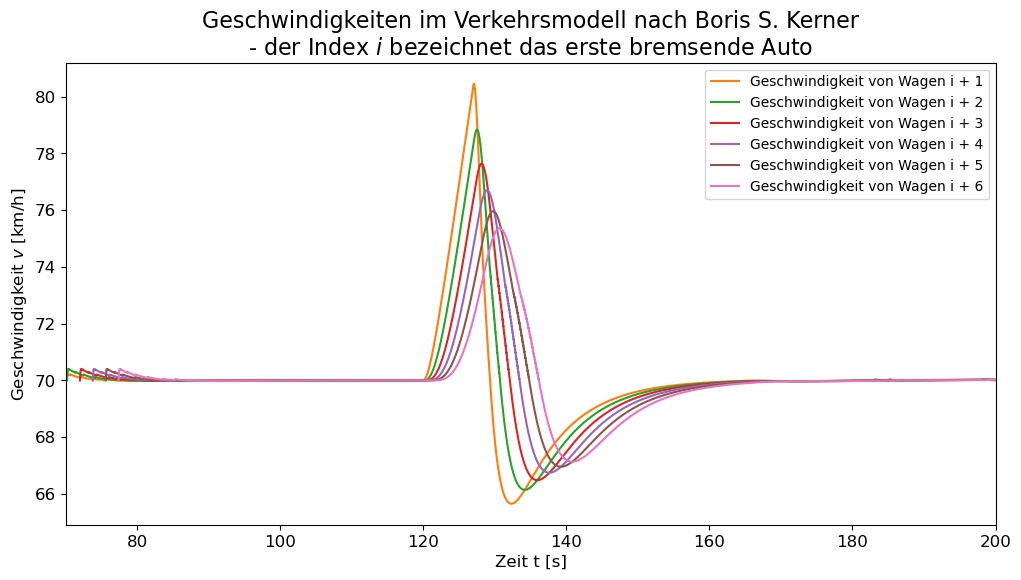

PyObject Text(0.5, 1.0, 'Geschwindigkeiten im Verkehrsmodell nach Boris S. Kerner\n- der Index $i$ bezeichnet das erste bremsende Auto')

In [142]:
figure(figsize=(12,6))
plot((100,100),(70,70))
for i in Wagennummern_ar #movement_Index_numbers
    if i ≠ Wagennummern1
        plot(movement_vec[i][1] , 3.6*movement_vec[i][3] ,
        linestyle="-", label="Geschwindigkeit von Wagen i + $(movement_vec[i][5]-Wagennummern1)")#, color="tab:blue")
    end
end

xlabel("Zeit t [s]", loc="center",fontsize=12)
ylabel("Geschwindigkeit "*L"v"*" [km/h]",fontsize=12)

xticks(fontsize=12)  # Größe der x-Achsen-Ticklabels
yticks(fontsize=12)  # Größe der y-Achsen-Ticklabels
xlim([70.0, 200.0])
#ylim([60.0, 85.0])

legend()
title("Geschwindigkeiten im Verkehrsmodell nach Boris S. Kerner
- der Index "*L"i"*" bezeichnet das erste bremsende Auto",fontsize=16)
#savefig("C:/Users/Fliese/Desktop/Master-Arbeit/Kerner-Modell/Bilder/Geschwindigkeitsverteilung nach dem Bremser 2.svg",
#bbox_inches="tight")

In [143]:
typeof(3:4)
#collect(3:4)*collect(7:8)

UnitRange{Int64}

In [144]:
# Zahlenreihen erstellen
zahlenreihe1 = 1:5 ; zahlenreihe2 = 11:15
mein_tuple1 = collect(zahlenreihe1) ; mein_tuple2 = collect(zahlenreihe2)

verknuepftes_array = vcat(mein_tuple1,mein_tuple2)

# Ausgabe des verknüpften Arrays
#println(verknuepftes_array)

for i in verknuepftes_array
    println(i)
end

1
2
3
4
5
11
12
13
14
15


In [145]:
# Check: Stimmt alles mit der Werteausgabe in den Vektor s_vec_export?
#=
println(length(s_vec_export))
println(" ")
for i in 162:1:171
    println("t = $(t_vec_export[i]) , s = $(s_vec_export[i])")
end
println(" ")

for i in 322:1:331
    println("t = $(t_vec_export[i]) , s = $(s_vec_export[i])")
end
=#

In [146]:
t_vec_export
#, s_vec_export , v_vec_export , a_vec_export , vehicle_n_vec_export ,
#new_car_number_export

30001-element Vector{Any}:
   0
   0.01
   0.02
   0.03
   0.04
   0.05
   0.06
   0.07
   0.08
   0.09
   0.1
   0.11
   0.12
   ⋮
 299.89
 299.90000000000003
 299.91
 299.92
 299.93
 299.94
 299.95
 299.96
 299.97
 299.98
 299.99
 300.0

In [147]:
length(vehicle_n_vec_export[6000])

281

In [148]:
s_vec_export[6001][length(s_vec_export[6001])]

9996.707553526281

In [149]:
#vehicle_n_vec_export

In [150]:
#length(movement_vec[1][2])
#length(movement_vec[1][3])
#movement_vec[1][3]

In [151]:
#movement_vec[2]

In [152]:
new_car_number_export

452

In [154]:
# Daten erstellen
plot3d_t = []
plot3d_s = []
plot3d_v = []
for car_Index in 1 : new_car_number_export
    push!(plot3d_t, [])
    push!(plot3d_s, [])
    push!(plot3d_v, [])
    len_t = length(movement_vec[car_Index][1])
    len_s = length(movement_vec[car_Index][2])
    len_v = length(movement_vec[car_Index][3])
    mini = min(len_t, len_s, len_v)
    for t_Index in 1: mini
        if movement_vec[car_Index][2][t_Index] < 4000 
            # Achtung !!! Wir betrachten hier nur Werte innerhalb der ersten 4 km der Strecke
            # Der Wert 4 km ist arbiträr gewählt. Benjamin Blümchen
            push!(plot3d_t[car_Index], movement_vec[car_Index][1][t_Index])
            push!(plot3d_s[car_Index], movement_vec[car_Index][2][t_Index])
            push!(plot3d_v[car_Index], movement_vec[car_Index][3][t_Index])
        end
    end
end

In [ ]:
#using Plots

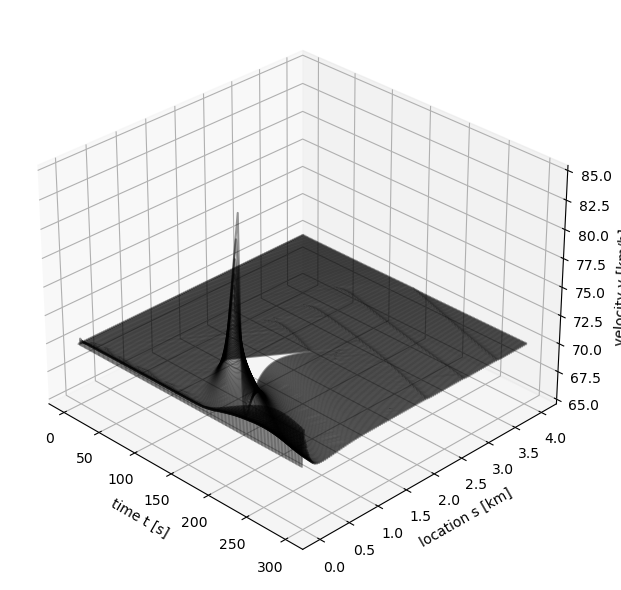

In [158]:
# 3D-Plot erstellen
fig = figure(figsize=(12,6))
ax = fig.add_subplot(111, projection="3d")

for car_Index in 1 : new_car_number_export
    ax.plot(plot3d_t[car_Index], plot3d_s[car_Index]/1000, 3.6 *plot3d_v[car_Index], color="k", alpha=0.4)
end

# Achsenbeschriftungen hinzufügen
ax.set_xlabel("time t [s]")
ax.set_ylabel("location s [km]")
ax.set_zlabel("velocity v [km/h]")#, loc="center")
#ax.set_title("3D-Plot")
tight_layout()

#subplots_adjust(left=0.4, right=2.9, top=0.9, bottom=0.1)  # Hier können Sie die Werte anpassen
#ax.set_ylim(0, 4)
ax.set_zlim(65, 85)

ax.zaxis.labelpad = -2.3  # Ändern Sie diesen Wert nach Bedarf
ax.view_init(azim=-45)

show()
#savefig("C:/Users/Fliese/Desktop/Master-Arbeit/Kerner-Modell/Bilder/der Bremser - 3D-Plot s-v-t.svg", bbox_inches="tight")

# Fundamentaldiagramm eventuell auch???

# Color-Plot - Geschwindigsverteilung im s-t-Feld

## Messdaten reduzieren - für 1 h gibt es 0,36 Mio Zeit-Datenpunkte

In [65]:
length(t_vec_export)

30001

In [66]:
Startzeit = now()
println("Startzeit    = $Startzeit")

reduction_param = 10

t_vec_red = []
s_vec_red = []
v_vec_red = []

#Progressmeter 1
h100percent = length(t_vec_export)
progress1_param1 = 0
progress1_param2 = 0

for i in 1:length(t_vec_export)
    if mod(i-1, reduction_param) == 0
        push!(t_vec_red , t_vec_export[i]/60)
        push!(s_vec_red , s_vec_export[i]/1000)
        push!(v_vec_red , v_vec_export[i]*3.6)
    end
    #Progressmeter 1
    progress1_param1 = progress1_param1 + 1/h100percent
    if progress1_param1 ≥ 0.1
        progress1_param2 = progress1_param2 + 10
        println("progress1 = $progress1_param2 %")
        progress1_param1 = progress1_param1 - 0.1
    end
end

Zwischenzeit = now()
println("Zwischenzeit = $Zwischenzeit")



Startzeit    = 2024-01-16T01:41:33.120
progress1 = 10 %
progress1 = 20 %
progress1 = 30 %
progress1 = 40 %
progress1 = 50 %
progress1 = 60 %
progress1 = 70 %
progress1 = 80 %
progress1 = 90 %
progress1 = 100 %
Zwischenzeit = 2024-01-16T01:41:34.007


In [67]:
length(t_vec_red)

3001

## Daten interpolieren - Eigene Interpolationsfunktionen

In [68]:
function linear_intra_extrapolation(s_vec, v_vec, s_val) #neu
    lens              = length(s_vec)
    s_pos_Index       = 0
    v_value_to_export = 0
    
    x_vals = zeros(2)
    y_vals = zeros(2)
    matrix_lgs = zeros(2,2)
    params_vec = zeros(2)
    
    if s_val < s_vec[1]
        s_pos_Index = 0
    elseif s_val ≥ s_vec[lens]
        s_pos_Index = lens
    else
        for pos_Index in 1:(lens - 1) #lens
            if s_vec[pos_Index] ≤ s_val < s_vec[pos_Index + 1]
                s_pos_Index = pos_Index
                break
            end
        end
    end
    
    if s_pos_Index ≠ 0 && s_vec[s_pos_Index] == s_val
        v_value_to_export = v_vec[s_pos_Index]
    elseif s_pos_Index == 0 || ( s_pos_Index > 0 && s_vec[s_pos_Index] < s_val)
        if s_pos_Index ≤ 1
            x_vals[1] = s_vec[1] ; x_vals[2] = s_vec[2]
            y_vals[1] = v_vec[1] ; y_vals[2] = v_vec[2]
            
        elseif 1 < s_pos_Index < (lens - 1)
            x_vals[1] = s_vec[s_pos_Index]; x_vals[2] = s_vec[s_pos_Index + 1];
            y_vals[1] = v_vec[s_pos_Index]; y_vals[2] = v_vec[s_pos_Index + 1];
                            
        elseif (lens - 1) ≤ s_pos_Index
            x_vals[1] = s_vec[lens - 1] ; x_vals[2] = s_vec[lens] ;
            y_vals[1] = v_vec[lens - 1] ; y_vals[2] = v_vec[lens] ;
            
        end
            
        for i in 1:2
            for j in 1:2
                matrix_lgs[i,j] = (x_vals[i])^(j-1)
            end
        end
        params_vec = inv(matrix_lgs)*y_vals
        v_value_to_export = params_vec[1] + params_vec[2] * s_val
    end
    return v_value_to_export
end

linear_intra_extrapolation (generic function with 1 method)

In [69]:
function cubic_intra_extrapolation(s_vec, v_vec, s_val) #neu
    lens              = length(s_vec)
    s_pos_Index       = 0
    v_value_to_export = 0
    
    x_vals = zeros(4)
    y_vals = zeros(4)
    matrix_lgs = zeros(4,4)
    params_vec = zeros(4)
    
    if s_val < s_vec[1]
        s_pos_Index = 0
    elseif s_val ≥ s_vec[lens]
        s_pos_Index = lens
    else
        for pos_Index in 1:(lens - 1) #lens
            if s_vec[pos_Index] ≤ s_val < s_vec[pos_Index + 1]
                s_pos_Index = pos_Index
                break
            end
        end
    end
    
    if s_pos_Index ≠ 0 && s_vec[s_pos_Index] == s_val
        v_value_to_export = v_vec[s_pos_Index]
    elseif s_pos_Index == 0 || ( s_pos_Index > 0 && s_vec[s_pos_Index] < s_val)
        if s_pos_Index ≤ 2
            x_vals[1] = s_vec[1] ; x_vals[2] = s_vec[2] ; x_vals[3] = s_vec[3] ; x_vals[4] = s_vec[4]
            y_vals[1] = v_vec[1] ; y_vals[2] = v_vec[2] ; y_vals[3] = v_vec[3] ; y_vals[4] = v_vec[4]
            
        elseif 2 < s_pos_Index < (lens - 2)
            x_vals[1] = s_vec[s_pos_Index - 1]; x_vals[2] = s_vec[s_pos_Index];
            x_vals[3] = s_vec[s_pos_Index + 1]; x_vals[4] = s_vec[s_pos_Index + 2]
            
            y_vals[1] = v_vec[s_pos_Index - 1]; y_vals[2] = v_vec[s_pos_Index];
            y_vals[3] = v_vec[s_pos_Index + 1]; y_vals[4] = v_vec[s_pos_Index + 2]
                
        elseif (lens - 2) ≤ s_pos_Index
            x_vals[1] = s_vec[lens - 3] ; x_vals[2] = s_vec[lens - 2] ;
            x_vals[3] = s_vec[lens - 1] ; x_vals[4] = s_vec[lens]
            
            y_vals[1] = v_vec[lens - 3] ; y_vals[2] = v_vec[lens - 2] ;
            y_vals[3] = v_vec[lens - 1] ; y_vals[4] = v_vec[lens]
        end
            
        for i in 1:4
            for j in 1:4
                matrix_lgs[i,j] = (x_vals[i])^(j-1)
            end
        end
        params_vec = inv(matrix_lgs)*y_vals
        v_value_to_export = params_vec[1] + params_vec[2] * s_val + params_vec[3] * s_val^2 + params_vec[4] * s_val^3
    end
    return v_value_to_export
end

cubic_intra_extrapolation (generic function with 1 method)

In [70]:
function fifth_degree_intra_extrapolation(s_vec, v_vec, s_val) #neu
    lens              = length(s_vec)
    s_pos_Index       = 0
    v_value_to_export = 0
    
    x_vals = zeros(6)
    y_vals = zeros(6)
    matrix_lgs = zeros(6,6)
    params_vec = zeros(6)
    
    if s_val < s_vec[1]
        s_pos_Index = 0
    elseif s_val ≥ s_vec[lens]
        s_pos_Index = lens
    else
        for pos_Index in 1:(lens - 1) #lens
            if s_vec[pos_Index] ≤ s_val < s_vec[pos_Index + 1]
                s_pos_Index = pos_Index
                break
            end
        end
    end
    
    if s_pos_Index ≠ 0 && s_vec[s_pos_Index] == s_val
        v_value_to_export = v_vec[s_pos_Index]
    elseif s_pos_Index == 0 || ( s_pos_Index > 0 && s_vec[s_pos_Index] < s_val)
        if s_pos_Index ≤ 4 # 4?
            x_vals[1] = s_vec[1] ; x_vals[2] = s_vec[2]
            x_vals[3] = s_vec[3] ; x_vals[4] = s_vec[4]
            x_vals[5] = s_vec[5] ; x_vals[6] = s_vec[6]
            
            y_vals[1] = v_vec[1] ; y_vals[2] = v_vec[2]
            y_vals[3] = v_vec[3] ; y_vals[4] = v_vec[4]
            y_vals[5] = v_vec[5] ; y_vals[6] = v_vec[6] 
            
        elseif 4 < s_pos_Index < (lens - 4)
            x_vals[1] = s_vec[s_pos_Index - 2] ; x_vals[2] = s_vec[s_pos_Index - 1];
            x_vals[3] = s_vec[s_pos_Index + 0] ; x_vals[4] = s_vec[s_pos_Index + 1]
            x_vals[5] = s_vec[s_pos_Index + 2] ; x_vals[6] = s_vec[s_pos_Index + 3]
            
            y_vals[1] = v_vec[s_pos_Index - 2] ; y_vals[2] = v_vec[s_pos_Index - 1];
            y_vals[3] = v_vec[s_pos_Index + 0] ; y_vals[4] = v_vec[s_pos_Index + 1]
            y_vals[5] = v_vec[s_pos_Index + 2] ; y_vals[6] = v_vec[s_pos_Index + 3]
                
        elseif (lens - 4) ≤ s_pos_Index
            x_vals[1] = s_vec[lens - 5] ; x_vals[2] = s_vec[lens - 4] ;
            x_vals[3] = s_vec[lens - 3] ; x_vals[4] = s_vec[lens - 2]
            x_vals[5] = s_vec[lens - 1] ; x_vals[6] = s_vec[lens]
            
            y_vals[1] = v_vec[lens - 5] ; y_vals[2] = v_vec[lens - 4] ;
            y_vals[3] = v_vec[lens - 3] ; y_vals[4] = v_vec[lens - 2]
            y_vals[5] = v_vec[lens - 1] ; y_vals[6] = v_vec[lens]
        end
            
        for i in 1:6
            for j in 1:6
                matrix_lgs[i,j] = (x_vals[i])^(j-1)
            end
        end
        params_vec = inv(matrix_lgs)*y_vals
        v_value_to_export = params_vec[1] + params_vec[2] * s_val + params_vec[3] * s_val^2 + params_vec[4] * s_val^3 + params_vec[5] * s_val^4 + params_vec[6] * s_val^5
    end
    return v_value_to_export
end

fifth_degree_intra_extrapolation (generic function with 1 method)

In [71]:
function seventh_degree_intra_extrapolation(s_vec, v_vec, s_val) #neu
    lens              = length(s_vec)
    s_pos_Index       = 0
    v_value_to_export = 0
    
    x_vals = zeros(8)
    y_vals = zeros(8)
    matrix_lgs = zeros(8,8)
    params_vec = zeros(8)
    
    if s_val < s_vec[1]
        s_pos_Index = 0
    elseif s_val ≥ s_vec[lens]
        s_pos_Index = lens
    else
        for pos_Index in 1:(lens - 1) #lens
            if s_vec[pos_Index] ≤ s_val < s_vec[pos_Index + 1]
                s_pos_Index = pos_Index
                break
            end
        end
    end
    
    if s_pos_Index ≠ 0 && s_vec[s_pos_Index] == s_val
        v_value_to_export = v_vec[s_pos_Index]
    elseif s_pos_Index == 0 || ( s_pos_Index > 0 && s_vec[s_pos_Index] < s_val)
        if s_pos_Index ≤ 6 # 4?
            x_vals[1] = s_vec[1] ; x_vals[2] = s_vec[2]
            x_vals[3] = s_vec[3] ; x_vals[4] = s_vec[4]
            x_vals[5] = s_vec[5] ; x_vals[6] = s_vec[6]
            x_vals[7] = s_vec[7] ; x_vals[8] = s_vec[8]
            
            y_vals[1] = v_vec[1] ; y_vals[2] = v_vec[2]
            y_vals[3] = v_vec[3] ; y_vals[4] = v_vec[4]
            y_vals[5] = v_vec[5] ; y_vals[6] = v_vec[6]
            y_vals[7] = v_vec[7] ; y_vals[8] = v_vec[8]
            
        elseif 6 < s_pos_Index < (lens - 6)
            x_vals[1] = s_vec[s_pos_Index - 3] ; x_vals[2] = s_vec[s_pos_Index - 2]
            x_vals[3] = s_vec[s_pos_Index - 1] ; x_vals[4] = s_vec[s_pos_Index + 0]
            x_vals[5] = s_vec[s_pos_Index + 1] ; x_vals[6] = s_vec[s_pos_Index + 2]
            x_vals[7] = s_vec[s_pos_Index + 3] ; x_vals[8] = s_vec[s_pos_Index + 4]
            
            y_vals[1] = v_vec[s_pos_Index - 3] ; y_vals[2] = v_vec[s_pos_Index - 2]
            y_vals[3] = v_vec[s_pos_Index - 1] ; y_vals[4] = v_vec[s_pos_Index + 0]
            y_vals[5] = v_vec[s_pos_Index + 1] ; y_vals[6] = v_vec[s_pos_Index + 2]
            y_vals[7] = v_vec[s_pos_Index + 3] ; y_vals[8] = v_vec[s_pos_Index + 4]
                
        elseif (lens - 6) ≤ s_pos_Index
            x_vals[1] = s_vec[lens - 7] ; x_vals[2] = s_vec[lens - 6]
            x_vals[3] = s_vec[lens - 5] ; x_vals[4] = s_vec[lens - 4]
            x_vals[5] = s_vec[lens - 3] ; x_vals[6] = s_vec[lens - 2]
            x_vals[7] = s_vec[lens - 1] ; x_vals[8] = s_vec[lens]
            
            y_vals[1] = v_vec[lens - 7] ; y_vals[2] = v_vec[lens - 6]
            y_vals[3] = v_vec[lens - 5] ; y_vals[4] = v_vec[lens - 4]
            y_vals[5] = v_vec[lens - 3] ; y_vals[6] = v_vec[lens - 2]
            y_vals[7] = v_vec[lens - 1] ; y_vals[8] = v_vec[lens]
        end
            
        for i in 1:8
            for j in 1:8
                matrix_lgs[i,j] = (x_vals[i])^(j-1)
            end
        end
        params_vec = inv(matrix_lgs)*y_vals
        v_value_to_export = (params_vec[1] + params_vec[2] * s_val + params_vec[3] * s_val^2 + params_vec[4] * s_val^3 
            + params_vec[5] * s_val^4 + params_vec[6] * s_val^5 + params_vec[7] * s_val^6 + params_vec[8] * s_val^7)
    end
    return v_value_to_export
end

seventh_degree_intra_extrapolation (generic function with 1 method)

## Interpolation mit eigener Interpolationsfunktion durchführen

In [34]:
length(s_vec_distanz) , L_input , length(t_vec_red)

LoadError: UndefVarError: `s_vec_distanz` not defined

In [72]:
Startzeit = now()
println("Startzeit = $Startzeit")

# Ortsraster, an das die v-s-Daten für jeden Zeitpunkt gefittet werden
step = L_input / 10^6
s_vec_distanz = collect(0:step:L_input/1000) 

# Erstellen einer Matrix für die Aufnahme der Interpolationswerte
v_interp_values = zeros(length(s_vec_distanz) , length(t_vec_red))

#Progressmeter 1
h100percent = length(t_vec_red)
println("h100percent = $h100percent")
progress1_param1 = 0
progress1_param2 = 0

for i in 1:length(t_vec_red)
    s_in = s_vec_red[i]
    v_in = v_vec_red[i]

    for j in 1:length(s_vec_distanz)
        #x_val = s_vec_distanz[length(s_vec_distanz) + 1 - j] # für imshow
        x_val = s_vec_distanz[j] # für pcolormesh
        
        #interp_values[j, i] = cubic_intra_extrapolation(s_in, v_in, x_val)
        v_interp_values[j, i] = fifth_degree_intra_extrapolation(s_in, v_in, x_val)
        #v_interp_values[j, i] = seventh_degree_intra_extrapolation(s_in, v_in, x_val)
    end
    
    #Progressmeter 1
    progress1_param1 = progress1_param1 + 1/h100percent
    if progress1_param1 ≥ 0.1
        progress1_param2 = progress1_param2 + 10
        jetzt = now()
        println("$jetzt   progress = $progress1_param2 %")
        progress1_param1 = progress1_param1 - 0.1
    end
end
#Klaus die Maus

Zielzeit = now()
println("Endzeit   = $Zielzeit")

Startzeit = 2024-01-16T01:41:53.148
h100percent = 3001
2024-01-16T01:42:47.358   progress = 10 %
2024-01-16T01:42:48.835   progress = 20 %
2024-01-16T01:42:54.001   progress = 30 %
2024-01-16T01:42:55.121   progress = 40 %
2024-01-16T01:42:56.371   progress = 50 %
2024-01-16T01:42:57.966   progress = 60 %
2024-01-16T01:42:59.169   progress = 70 %
2024-01-16T01:43:00.866   progress = 80 %
2024-01-16T01:43:02.016   progress = 90 %
2024-01-16T01:43:03.334   progress = 100 %
Endzeit   = 2024-01-16T01:43:03.364


## Plot mit pcolormesh

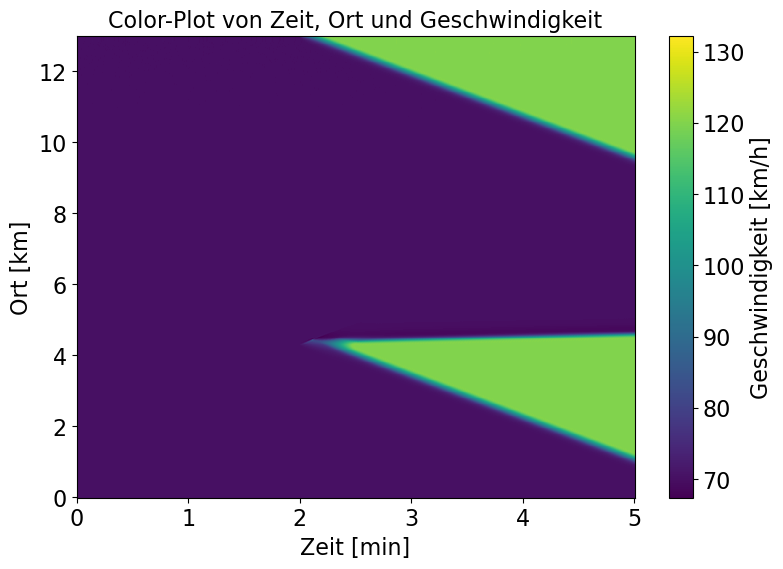

PyObject Text(0.5, 1.0, 'Color-Plot von Zeit, Ort und Geschwindigkeit')

In [73]:
figure(figsize=(9,6))
pcolormesh(t_vec_red, s_vec_distanz, v_interp_values, shading="auto")
#plot((0,60),(2,2), "--", color="k", alpha=0.8, linewidth=0.8)
#plot((0,60),(5,5), "--", color="k", alpha=0.8, linewidth=0.8)
cbar = colorbar()#label="Geschwindigkeit [km/h]")
cbar.set_label("Geschwindigkeit [km/h]", fontsize=16)  # Hier die Schriftgröße anpassen
cbar.ax.tick_params(labelsize=16)  # Hier die Schriftgröße anpassen
xlabel("Zeit [min]", fontsize=16)
ylabel("Ort [km]", fontsize=16)
xticks(fontsize=16)
yticks(fontsize=16)
title("Color-Plot von Zeit, Ort und Geschwindigkeit", fontsize=16)
#show()

#savefig("C:/Users/Fliese/Desktop/Kerner-Modell/jupyter notebooks Kerner-Modell/Kerner Colorplot MSP.svg",
#bbox_inches="tight")
#savefig("C:/Users/Fliese/Desktop/Kerner-Modell/jupyter notebooks Kerner-Modell/Kerner Colorplot MSP.png",
#bbox_inches="tight")

# Das Maximum kommt vermutlich durch die Interpolation

In [74]:
Startzeit = now()
println("Startzeit = $Startzeit")

# Daten für den Color-Plot vorbereiten
x_vals = []  # Zeitwerte
y_vals = []  # Ortswerte
c_vals = []  # Geschwindigkeitswerte

#Progressmeter 2
h100percent2 = length(t_vec_red)
progress2_param1 = 0
progress2_param2 = 0

for (t_Index, t_val) in enumerate(t_vec_red)
    s_vals = s_vec_red[t_Index]
    v_vals = v_vec_red[t_Index]

    for (Index2, s_val) in enumerate(s_vals)
        push!(x_vals, t_val)
        push!(y_vals, s_val)
        push!(c_vals, v_vals[Index2])
    end
    #Progressmeter 2
    progress2_param1 = progress2_param1 + 1/h100percent2
    if progress2_param1 ≥ 0.1
        progress2_param2 = progress2_param2 + 10
        jetzt = now()
        println("$jetzt   - progress = $progress2_param2 %")
        progress2_param1 = progress2_param1 - 0.1
    end
end

Zielzeit = now()
println("Endzeit      = $Zielzeit")

Startzeit = 2024-01-16T01:43:40.158
2024-01-16T01:43:40.728   - progress = 10 %
2024-01-16T01:43:40.828   - progress = 20 %
2024-01-16T01:43:41.416   - progress = 30 %
2024-01-16T01:43:41.497   - progress = 40 %
2024-01-16T01:43:41.567   - progress = 50 %
2024-01-16T01:43:41.656   - progress = 60 %
2024-01-16T01:43:41.729   - progress = 70 %
2024-01-16T01:43:41.810   - progress = 80 %
2024-01-16T01:43:41.881   - progress = 90 %
2024-01-16T01:43:41.979   - progress = 100 %
Endzeit      = 2024-01-16T01:43:41.982


Startzeit = 2024-01-16T01:43:47.872
Endzeit   = 2024-01-16T01:43:55.671


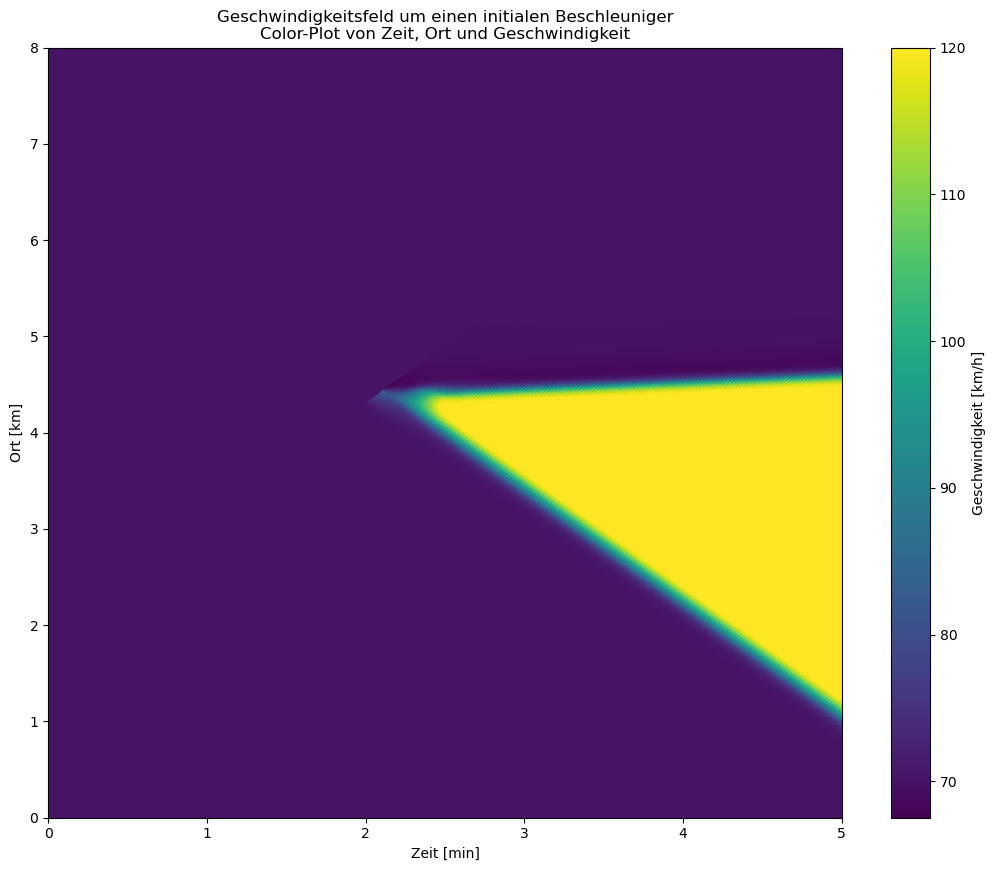

In [75]:
Startzeit = now()
println("Startzeit = $Startzeit")
t_end_min = t_end_input / 60

figure(figsize=(12.8,10)) #(6.4,5)
# Color-Plot mit Rechtecken erstellen
scatter(x_vals, y_vals, c=c_vals, cmap="viridis", 
                marker=:s,
                s=1, #50
                linewidth=1)#, edgecolor="black")
colorbar(label="Geschwindigkeit [km/h]")

# Achsentitel und Beschriftungen hinzufügen
xlabel("Zeit [min]")
ylabel("Ort [km]")
xlim([0,t_end_min])
ylim([0,8])
title("Geschwindigkeitsfeld um einen initialen Beschleuniger\nColor-Plot von Zeit, Ort und Geschwindigkeit")

# Plot anzeigen
show()

Zielzeit = now()
println("Endzeit   = $Zielzeit")
#savefig("C:/Users/Fliese/Desktop/Kerner-Modell/jupyter notebooks Kerner-Modell/Bilder Figure 3/Beschleuniger Colorplot.svg",
#    bbox_inches="tight")
savefig("C:/Users/Fliese/Desktop/Kerner-Modell/jupyter notebooks Kerner-Modell/Bilder Figure 3/Beschleuniger Colorplot.png",
    bbox_inches="tight")

In [ ]:
Zielzeit = now()
println("Endzeit   = $Zielzeit")

In [ ]:
#Δ